# 09__tbs_identification
# finding functional TFBSs based on deletion data

in this notebook, i find "peaks" in the deletion data, defined as any stretch of >= 5 nucleotides with effect sizes of <= -1.5 * the average standard deviation of the deletion effect sizes in that tile. (scaling by the standard deviation ensures that extremely noisy tiles will have higher thresholds for peak calling). then, i intersect the mapped FIMO motifs with these peaks, and consider "functional" motifs to be those that overlap a peak by at least 1 nucleotide. i also limit the motifs to only those that are expressed in the given cell type. i make a heatmap of all of the predicted "functional" TF motifs across all of the lncRNAs we examined, and i examine patterns between tile specificity and the number of functional motifs in the tile.

------

figures in this notebook:
- **Fig 3E**: barplot of deletion effect sizes and sequence logo plotted proportionally to the loss scores of lncRNA DLEU1 promoter (DLEU1_HepG2). 
- **Fig 3D, S10**: heatmap showing all of the functional TFBSs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *
from del_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
del_dir = "../../data/05__deletions"
out_dir = "../../data/06__tfbs_results"

In [4]:
# file w/ tfs and their expression
tf_expr_f = "../../data/04__coverage/TF_tissue_specificities.from_CAGE.txt"

In [5]:
fimo_f = "../../misc/03__fimo/pool2_fimo_map.txt"

In [6]:
index_f = "../../data/00__index/dels_oligo_pool.index.txt"

In [7]:
peak_signal_cutoff = 1.5
peak_length_cutoff = 5
del_buffer = 11
seq_len = 94

## 1. import deletion data and tf expr file

In [8]:
# hepg2
hepg2_files = []
for (dirpath, dirnames, filenames) in walk("%s/HepG2" % del_dir):
    hepg2_files.extend(filenames)
    break

In [9]:
# k562
k562_files = []
for (dirpath, dirnames, filenames) in walk("%s/K562" % del_dir):
    k562_files.extend(filenames)
    break

In [10]:
hepg2_data = {}
k562_data = {}
for files, data, cell in zip([hepg2_files, k562_files], [hepg2_data, k562_data], ["HepG2", "K562"]):
    data_dir = "%s/%s" % (del_dir, cell)
    for f in files:
        df = pd.read_table("%s/%s" % (data_dir, f))
        data[f] = df

In [11]:
# import tf expr data
tf_expr = pd.read_table(tf_expr_f, sep="\t")
tf_expr.head()

,tf,tissue_sp_all,tissue_sp_3,K562_exp,HeLa_exp,HepG2_exp
0,PAX7,0.990032,NaN,0.000000,0.000000,0.000000
1,HNF1B,0.979589,0.666667,0.000000,0.000000,5.889702
2,LIN54,0.794230,0.412303,17.857032,18.290625,47.369957
3,IRF3,0.719361,0.089475,23.938784,29.128210,26.498907
4,MEF2C,0.978378,0.665278,112.089652,0.335948,0.131145


In [12]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo.columns = ["motif", "unique_id", "start", "stop", "strand", "score", "p-value", "q-value", "seq"]
fimo.head()

,motif,unique_id,start,stop,strand,score,p-value,q-value,seq
0,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,59,-,27.0204,4.070000e-11,0.000024,GGAGGAGGGAGGGGAGGGGAG
1,ZNF263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,24,44,+,26.6735,6.730000e-11,0.000024,GGAGGAGGAAGAGGGAGAGGG
2,RREB1,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.flip.sense...,24,43,-,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
3,RREB1,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,71,90,+,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC
4,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,38,58,-,25.3878,3.590000e-10,0.000024,GAGGGAGGGAGGGGAGGGGGG


In [13]:
# filter to tfs that are expr in the 2 cell lines
hepg2_tfs = tf_expr[tf_expr["HepG2_exp"] > 0.1]["tf"]
k562_tfs = tf_expr[tf_expr["K562_exp"] > 0.1]["tf"]

In [14]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["unique_id", "tile_name", "chr", "tile_start", "tile_end", "strand", "tile_number"]].drop_duplicates()
index_elem.head()

,unique_id,tile_name,chr,tile_start,tile_end,strand,tile_number
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
80,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
106,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
132,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0
158,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187624.0,-,2.0


## 2. filter dfs to only those that are sig active (wt_class) and make loss score

In [15]:
def loss_score(row):
    if row["mean.log2FC"] < 0:
        return -row["mean.log2FC"]
    else:
        return 0

In [16]:
hepg2_data_filt = {}
k562_data_filt = {}
for data, data_filt in zip([hepg2_data, k562_data], [hepg2_data_filt, k562_data_filt]):
    for key in data:
        df = data[key]
        if df.wt_class.iloc[0] == "sig active":
            df["loss_score"] = df.apply(loss_score, axis=1)
            data_filt[key] = df

## 3. find "peaks" in the deletion data

In [17]:
def find_peaks(df, peak_signal_cutoff, peak_length_cutoff):
    peak_status = []
    effect_sizes = list(df["mean.log2FC"])
    avg_sd = df["sd"].mean()
    count = 0
    in_peak = False
    overall_count = 1
    scaled_peak_signal_cutoff = avg_sd * peak_signal_cutoff
    print("sd: %s, scaled cutoff: %s" % (avg_sd, scaled_peak_signal_cutoff))
    for x in effect_sizes:
        if x <= -scaled_peak_signal_cutoff:
            count += 1
            if count >= peak_length_cutoff:
                if in_peak == False:
                    # replace the last peak_length_cutoff elements with "peak"
                    tmp = peak_status[:(-peak_length_cutoff-1)]
                    diff = len(peak_status) - len(tmp)
                    peak_status = list(tmp)
                    peak_status.extend(["peak"] * (diff+1))
                    in_peak = True
                else:
                    peak_status.append("peak")
            else:
                peak_status.append("no peak")
        else:
            in_peak = False
            count = 0
            peak_status.append("no peak")
        overall_count += 1
    df["peak"] = peak_status
    return df

In [18]:
hepg2_data_peaks = {}
k562_data_peaks = {}

for data_filt, data_peaks, cell in zip([hepg2_data_filt, k562_data_filt], [hepg2_data_peaks, k562_data_peaks],
                                       ["HepG2", "K562"]):
    for key in data_filt:
        name = key.split(".")[0]
        strand = key.split(".")[2]
        gene_name = "%s__%s" % (name, strand)
        print(gene_name)
        df = data_filt[key]
        df = find_peaks(df, peak_signal_cutoff, peak_length_cutoff)
        data_peaks[gene_name] = df
        
        # write file
        cell_dir = "%s/%s/0__peaks" % (out_dir, cell)
        !mkdir -p $cell_dir
        df.to_csv("%s/%s.tfbs_peaks.txt" % (cell_dir, gene_name), sep="\t", index=False)

enhancer_NEAT1__pX__tile2__minus
sd: 0.134284304872, scaled cutoff: 0.201426457307
enhancer_MALAT1__pX__tile1__minus
sd: 0.504934395085, scaled cutoff: 0.757401592628
enhancer_MALAT1__pX__tile2__minus
sd: 0.265573777643, scaled cutoff: 0.398360666465
enhancer_TERC__pX__tile2__minus
sd: 0.150803268754, scaled cutoff: 0.226204903131
enhancer_LINC_PINT__pX__tile1__minus
sd: 0.108510384618, scaled cutoff: 0.162765576927
FALEC__p1__tile2__plus
sd: 0.127697535457, scaled cutoff: 0.191546303185
GAS5__p1__tile1__minus
sd: 0.258683697641, scaled cutoff: 0.388025546462
GAS5__p1__tile2__minus
sd: 0.116046109874, scaled cutoff: 0.17406916481
ZBTB37__p1__tile1__plus
sd: 0.253135068719, scaled cutoff: 0.379702603078
ZBTB37__p1__tile2__plus
sd: 0.140864149491, scaled cutoff: 0.211296224236
LINC00467__p1__tile1__plus
sd: 0.422558557445, scaled cutoff: 0.633837836168
LINC00467__p1__tile2__plus
sd: 0.144561924909, scaled cutoff: 0.216842887364
NEAT1__p1__tile2__plus
sd: 0.185294785606, scaled cutoff: 0.

## 4. intersect FIMO motifs w/ peaks

In [19]:
fimo["fixed_name"] = fimo.apply(fix_fimo_names, name_dict=NAME_DICT, loc_dict=LOC_DICT, axis=1)
fimo.head()

,motif,unique_id,start,stop,strand,score,p-value,q-value,seq,fixed_name
0,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,59,-,27.0204,4.070000e-11,0.000024,GGAGGAGGGAGGGGAGGGGAG,LINC00467__p1__tile1__plus
1,ZNF263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__p1@IRX5__c...,24,44,+,26.6735,6.730000e-11,0.000024,GGAGGAGGAAGAGGGAGAGGG,IRX5__p1__tile1__plus
2,RREB1,WILDTYPE_BUT_HAS_SNP_DELETION__mrna.flip.sense...,24,43,-,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC,CDKN2A__p1__tile1__minus
3,RREB1,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,71,90,+,27.0550,3.310000e-10,0.000043,CCCCACCCCACCCCCACCCC,CDKN2A__p1__tile2__plus
4,ZNF263,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,38,58,-,25.3878,3.590000e-10,0.000024,GAGGGAGGGAGGGGAGGGGGG,LINC00467__p1__tile1__plus


In [20]:
def getOverlap(a, b):
    return max(a[0], b[0]) - min(a[1], b[1])


HepG2
enhancer_NEAT1__pX__tile2__minus
[5, 7, 26, 40, 41, 41, 41, 43, 62, 62, 63, 63, 63, 74, 75, 76, 76]
[24, 17, 40, 50, 51, 50, 50, 63, 72, 76, 73, 77, 72, 88, 88, 89, 86]


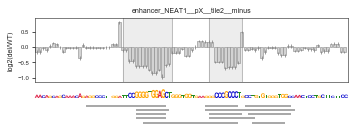

{'motif': ['HNF4G', 'SP1', 'Klf1', 'KLF5', 'Klf4', 'ZNF263', 'Klf1', 'Klf12', 'SP1', 'SP2', 'Klf4', 'EGR3', 'GLIS3', 'EGR1', 'EGR2'], 'start': [15, 29, 30, 30, 30, 32, 51, 51, 52, 52, 52, 63, 64, 65, 65], 'end': [29, 39, 40, 39, 39, 52, 61, 65, 62, 66, 61, 77, 77, 78, 75], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak']}
enhancer_MALAT1__pX__tile1__minus
[13, 21, 23, 25, 26, 27, 27, 28, 29, 30, 30, 30, 33, 33, 33, 34, 34, 34, 35, 38, 39, 49, 50, 62, 80, 81, 82, 82, 85, 85, 85, 85, 86, 86, 93, 96]
[26, 30, 37, 45, 46, 47, 42, 42, 43, 43, 46, 40, 43, 43, 43, 48, 43, 43, 45, 48, 48, 59, 62, 76, 94, 95, 98, 95, 95, 94, 95, 95, 95, 95, 107, 110]


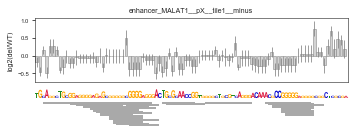

{'motif': ['Zfx', 'MZF1(var.2)', 'SP2', 'ZNF263', 'ZNF263', 'ZNF263', 'EGR4', 'EGR3', 'SP2', 'EGR1', 'SP4', 'EGR2', 'KLF16', 'SP1', 'SP3', 'SP2', 'Klf4', 'KLF5', 'E2F4', 'SP1', 'KLF5', 'NRF1', 'SCRT2', 'Bach1::Mafk', 'ZIC3', 'SP2', 'SP4', 'EGR1', 'SP1', 'ZNF740', 'SP3', 'KLF16', 'Klf4', 'KLF5'], 'start': [2, 10, 12, 14, 15, 16, 16, 17, 18, 19, 19, 19, 22, 22, 22, 23, 23, 23, 24, 27, 28, 38, 39, 51, 69, 70, 71, 71, 74, 74, 74, 74, 75, 75], 'end': [15, 19, 26, 34, 35, 36, 31, 31, 32, 32, 35, 29, 32, 32, 32, 37, 32, 32, 34, 37, 37, 48, 51, 65, 83, 84, 87, 84, 84, 83, 84, 84, 84, 84], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
enhancer_MALAT1__pX_

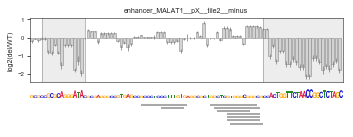

{'motif': ['ZIC3', 'Sox2', 'EGR3', 'SP2', 'EGR2', 'SP1', 'SP3', 'KLF16', 'NRF1'], 'start': [33, 39, 54, 55, 56, 59, 59, 59, 60], 'end': [47, 46, 68, 69, 66, 69, 69, 69, 70], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
enhancer_TERC__pX__tile2__minus
[1, 4, 4, 24, 24]
[21, 17, 17, 34, 32]


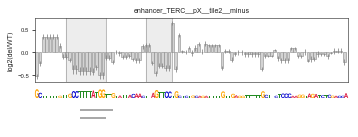

{'motif': ['CDX2', 'CDX1'], 'start': [13, 13], 'end': [23, 21], 'peak_overlap': ['in peak', 'in peak']}
enhancer_LINC_PINT__pX__tile1__minus
[10, 16, 36, 46, 67, 67, 68, 68, 73, 74, 74, 74, 75, 76, 80, 80, 80, 82, 82, 82, 82, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85]
[20, 26, 46, 65, 78, 78, 77, 77, 87, 84, 84, 87, 85, 96, 93, 93, 94, 93, 93, 94, 93, 93, 93, 93, 93, 93, 94, 93, 93, 93, 93, 93, 93, 93, 93, 93, 95]


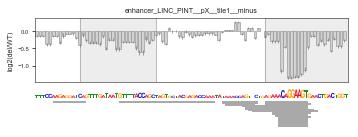

{'motif': ['Crx', 'HOXC13', 'PPARG', 'GRHL1', 'GRHL1', 'TFCP2', 'TFCP2', 'Stat6', 'STAT3', 'STAT1', 'Stat4', 'Stat5a::Stat5b', 'IRF1', 'SPI1', 'SPIC', 'STAT1::STAT2', 'ELF1', 'ELF4', 'ELF3', 'EHF', 'ELF5', 'ETV2', 'SPDEF', 'FEV', 'ETS1', 'ELK4', 'ELK3', 'ERF', 'ETV6', 'ETV1', 'ELK1', 'FLI1', 'ERG', 'ETV4', 'ETV3', 'Gabpa'], 'start': [5, 25, 35, 56, 56, 57, 57, 62, 63, 63, 63, 64, 65, 69, 69, 69, 71, 71, 71, 71, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74], 'end': [15, 35, 54, 67, 67, 66, 66, 76, 73, 73, 76, 74, 85, 82, 82, 83, 82, 82, 83, 82, 82, 82, 82, 82, 82, 83, 82, 82, 82, 82, 82, 82, 82, 82, 82, 84], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak'

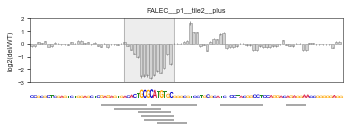

{'motif': ['Nfe2l2', 'MAF::NFE2', 'NRF1', 'NRF1', 'NHLH1', 'EGR3', 'GCM2', 'PLAG1', 'SPIB'], 'start': [21, 25, 32, 33, 34, 36, 38, 57, 77], 'end': [35, 39, 42, 43, 43, 50, 47, 70, 83], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak']}
GAS5__p1__tile1__minus
[2, 3, 3, 4, 6, 7, 8, 8, 9, 11, 11, 16, 18, 29, 33, 34, 35, 35, 56, 61, 68, 71, 72, 74, 75, 78, 79, 80, 80, 81, 82, 83, 83, 84, 96]
[22, 23, 17, 20, 26, 17, 17, 17, 19, 24, 25, 30, 31, 43, 43, 43, 45, 51, 76, 67, 88, 91, 92, 87, 89, 89, 93, 96, 89, 94, 93, 93, 93, 93, 107]


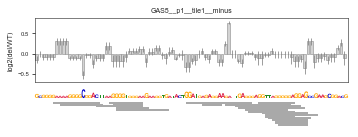

{'motif': ['SP2', 'KLF14', 'SP2', 'SP1', 'KLF5', 'E2F6', 'RARA::RXRA', 'ZNF263', 'SPIB', 'ZNF263', 'ZNF263', 'ZNF263', 'PLAG1', 'NR2C2', 'INSM1', 'SP2', 'SP4', 'MZF1(var.2)', 'KLF14', 'SP8', 'SP1', 'KLF16', 'KLF5'], 'start': [5, 7, 18, 22, 23, 24, 24, 45, 50, 57, 60, 61, 63, 64, 67, 68, 69, 69, 70, 71, 72, 72, 73], 'end': [19, 20, 32, 32, 32, 34, 40, 65, 56, 77, 80, 81, 76, 78, 78, 82, 85, 78, 83, 82, 82, 82, 82], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
GAS5__p1__tile2__minus
[2, 25, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 30, 30, 30, 32]
[13, 39, 38, 40, 40, 40, 40, 40, 39, 37, 39, 42, 39, 39, 41, 42, 36, 37, 37, 39, 39]


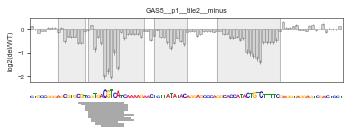

{'motif': ['JUND(var.2)', 'JUN', 'BATF3', 'BATF3', 'ATF7', 'ATF7', 'CREB3', 'JDP2(var.2)', 'Crem', 'Creb5', 'JUND(var.2)', 'JDP2(var.2)', 'Creb5', 'JUN', 'MTF1', 'Atf1', 'CREB1', 'CREB1', 'Crem', 'Atf3'], 'start': [14, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 21], 'end': [28, 27, 29, 29, 29, 29, 29, 28, 26, 28, 31, 28, 28, 30, 31, 25, 26, 26, 28, 28], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
ZBTB37__p1__tile1__plus
[15, 18, 19, 21, 24, 29, 31, 32, 33, 33, 33, 33, 34, 34, 35, 37, 37, 37, 39, 41, 42, 42, 42, 63, 64, 64, 65, 65, 66, 67, 69, 70, 71, 73, 73, 74, 74, 75, 75, 75, 76, 78, 79, 79, 79, 96, 102, 103, 104, 104, 104, 104, 104]
[35, 38, 39, 41, 44, 43, 45, 43, 43, 43, 43, 53, 43, 43, 49, 47, 50, 51, 59, 51, 51, 51, 59, 83, 83, 84, 82, 76, 75, 80, 82, 90, 91, 

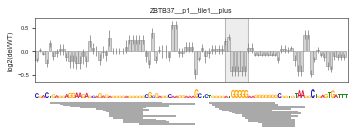

{'motif': ['ZNF263', 'ZNF263', 'ZNF263', 'ZNF263', 'ZNF263', 'SP2', 'NR2C2', 'SP8', 'SP3', 'SP1', 'KLF16', 'ZNF263', 'ZNF740', 'KLF5', 'SP2', 'NRF1', 'KLF14', 'ZBTB33', 'ZNF263', 'E2F4', 'Tcfl5', 'Tcfl5', 'EWSR1-FLI1', 'ZNF263', 'RREB1', 'ZNF263', 'EWSR1-FLI1', 'INSM1', 'MZF1(var.2)', 'EGR1', 'PLAG1', 'ZNF263', 'ZNF263', 'EGR4', 'EWSR1-FLI1', 'ZNF740', 'EGR3', 'KLF14', 'SP2', 'ZNF740', 'SP4', 'SP8', 'SP3', 'KLF16', 'SP1'], 'start': [4, 7, 8, 10, 13, 18, 20, 21, 22, 22, 22, 22, 23, 23, 24, 26, 26, 26, 28, 30, 31, 31, 31, 52, 53, 53, 54, 54, 55, 56, 58, 59, 60, 62, 62, 63, 63, 64, 64, 64, 65, 67, 68, 68, 68], 'end': [24, 27, 28, 30, 33, 32, 34, 32, 32, 32, 32, 42, 32, 32, 38, 36, 39, 40, 48, 40, 40, 40, 48, 72, 72, 73, 71, 65, 64, 69, 71, 79, 80, 77, 79, 72, 77, 77, 78, 73, 81, 78, 78, 78, 78], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no

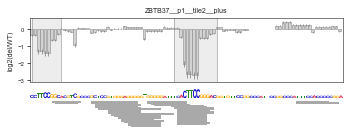

{'motif': ['HEY2', 'ARNT::HIF1A', 'ZIC3', 'ZIC4', 'ZIC1', 'SP2', 'GLIS3', 'GLIS2', 'EGR1', 'EGR2', 'KLF16', 'ZNF740', 'SP1', 'SP3', 'RREB1', 'Klf4', 'KLF5', 'SP2', 'MZF1(var.2)', 'EGR1', 'SP3', 'ZNF740', 'PLAG1', 'SP8', 'SP3', 'SP1', 'KLF16', 'Klf4', 'KLF5', 'NFKB1', 'NFKB1', 'REL', 'Ddit3::Cebpa', 'Gabpa', 'ELK4', 'ELF3', 'ELF4', 'ELF5', 'ETV6', 'EHF', 'ELF1', 'ETS1', 'ETV3', 'ELK1', 'ERF', 'ELK3', 'ERG', 'ETV4', 'FLI1', 'ETV1', 'FEV', 'SPDEF', 'ETV5', 'SP1', 'EGR1'], 'start': [6, 7, 18, 18, 19, 19, 19, 19, 20, 20, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 27, 27, 28, 29, 29, 29, 30, 30, 35, 35, 36, 37, 42, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 80, 80], 'end': [15, 14, 32, 32, 32, 33, 32, 32, 33, 30, 33, 32, 33, 33, 43, 33, 33, 39, 35, 39, 37, 36, 40, 39, 39, 39, 39, 39, 39, 47, 47, 45, 48, 52, 53, 55, 55, 54, 53, 55, 55, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 53, 90, 93], 'peak_overlap': ['in peak', 'in peak', 'no peak', 'no peak', 'no pea

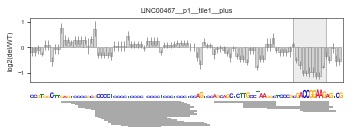

{'motif': ['SP4', 'PLAG1', 'KLF14', 'SP2', 'SP3', 'EWSR1-FLI1', 'KLF16', 'SP4', 'ZNF263', 'KLF5', 'SP3', 'Klf4', 'SP1', 'KLF16', 'SP8', 'ZNF263', 'SP2', 'ZNF263', 'ZNF263', 'ZNF263', 'MZF1(var.2)', 'EWSR1-FLI1', 'ZNF263', 'KLF16', 'ZNF263', 'SP1', 'SP2', 'KLF5', 'ZNF263', 'ZNF263', 'ZNF263', 'MZF1(var.2)', 'ZNF263', 'EWSR1-FLI1', 'KLF16', 'KLF5', 'ZNF263', 'SP2', 'SP1', 'EWSR1-FLI1', 'MZF1(var.2)', 'EWSR1-FLI1', 'KLF5', 'SP2', 'SP1', 'E2F6', 'EWSR1-FLI1', 'EWSR1-FLI1', 'SP1', 'KLF5', 'SP2', 'E2F6', 'MSC', 'TFAP2B(var.2)', 'TFAP2C(var.2)', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2A', 'TFAP2B(var.2)', 'E2F6', 'E2F4', 'ETV5', 'ELK1', 'ELK3', 'ERG', 'ETV1', 'ELK4', 'FEV', 'FLI1', 'ETS1', 'ETV4', 'Gabpa'], 'start': [9, 12, 13, 14, 14, 14, 14, 16, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 24, 24, 24, 25, 26, 27, 27, 28, 28, 29, 29, 29, 29, 29, 32, 32, 33, 34, 34, 34, 36, 36, 37, 38, 38, 38, 40, 55, 64, 64, 64, 64, 64, 64, 71, 71, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82],

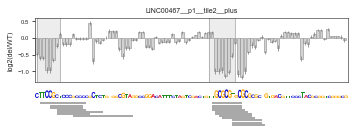

{'motif': ['EGR3', 'E2F4', 'E2F6', 'KLF5', 'SP2', 'SP1', 'PAX5', 'Hes1', 'Tcfl5', 'Tcfl5', 'NRF1', 'NRF1', 'HINFP', 'EGR2', 'NRF1', 'Tcfl5', 'Tcfl5', 'NRF1'], 'start': [1, 4, 4, 6, 6, 6, 11, 53, 53, 53, 53, 54, 54, 55, 56, 59, 59, 59], 'end': [15, 14, 14, 15, 20, 16, 29, 62, 62, 62, 63, 64, 65, 65, 66, 68, 68, 69], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
NEAT1__p1__tile2__plus
[15, 15, 24, 29, 30, 31, 38, 38, 45, 47, 48]
[31, 24, 38, 43, 43, 44, 49, 49, 55, 67, 62]


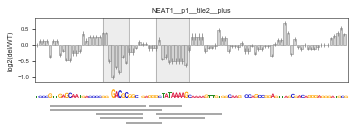

{'motif': ['NR1H2::RXRA', 'CEBPG', 'RXRA::VDR', 'Bach1::Mafk', 'CREB3L1', 'XBP1', 'TFAP2A(var.2)', 'TFAP2B', 'CDX2', 'IRF1', 'TBP'], 'start': [4, 4, 13, 18, 19, 20, 27, 27, 34, 36, 37], 'end': [20, 13, 27, 32, 32, 33, 38, 38, 44, 56, 51], 'peak_overlap': ['no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
MALAT1__p4__tile1__plus
[19, 20, 61, 64, 73, 76, 76, 76, 76, 76, 76, 76, 77, 77, 95]
[33, 27, 75, 78, 89, 86, 90, 89, 85, 86, 86, 85, 91, 86, 109]


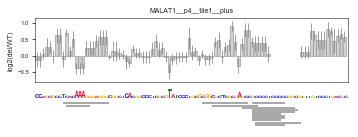

{'motif': ['ZIC3', 'Sox2', 'ZBTB33', 'ZBTB33', 'SP4', 'SP1', 'SP2', 'EGR1', 'KLF5', 'KLF16', 'SP3', 'Klf4', 'ZIC3', 'ZNF740'], 'start': [8, 9, 50, 53, 62, 65, 65, 65, 65, 65, 65, 65, 66, 66], 'end': [22, 16, 64, 67, 78, 75, 79, 78, 74, 75, 75, 74, 80, 75], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
MALAT1__p4__tile2__plus
[1, 15, 18, 29, 29, 29, 30, 31, 31, 32, 32, 34, 34, 34, 34, 34, 34, 34, 35, 35, 37, 40, 47, 51]
[15, 27, 28, 38, 43, 39, 50, 47, 51, 42, 52, 43, 47, 44, 48, 44, 43, 44, 50, 49, 47, 54, 56, 64]


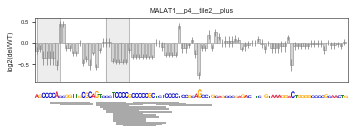

{'motif': ['SCRT2', 'NRF1', 'KLF5', 'SP2', 'SP1', 'ZNF263', 'SP4', 'ZNF263', 'E2F4', 'ZNF263', 'Klf4', 'EGR1', 'KLF16', 'SP2', 'SP1', 'KLF5', 'SP3', 'EGR4', 'EGR3', 'EGR2', 'SP2', 'MZF1(var.2)', 'Zfx'], 'start': [4, 7, 18, 18, 18, 19, 20, 20, 21, 21, 23, 23, 23, 23, 23, 23, 23, 24, 24, 26, 29, 36, 40], 'end': [16, 17, 27, 32, 28, 39, 36, 40, 31, 41, 32, 36, 33, 37, 33, 32, 33, 39, 38, 36, 43, 45, 53], 'peak_overlap': ['in peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak']}
MALAT1__p1__tile1__plus
[3, 3, 5, 19, 20, 20, 20, 56, 62]
[20, 17, 25, 33, 31, 31, 31, 63, 75]


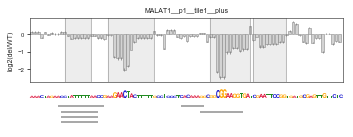

{'motif': ['MEF2C', 'MEF2A', 'MEF2B', 'MEF2D', 'Sox2', 'EGR1'], 'start': [8, 9, 9, 9, 45, 51], 'end': [22, 20, 20, 20, 52, 64], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'in peak']}
HOTAIR__p1__tile2__minus
[2, 25, 30, 32, 32, 32, 32, 33]
[16, 33, 40, 41, 41, 41, 43, 43]


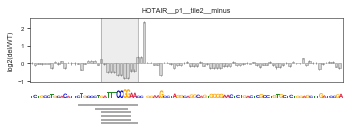

{'motif': ['THAP1', 'Gabpa', 'ERG', 'FLI1', 'FEV', 'ELF1', 'STAT3'], 'start': [14, 19, 21, 21, 21, 21, 22], 'end': [22, 29, 30, 30, 30, 32, 32], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
DLEU1__p1__tile1__plus
[18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 24, 25, 35, 36, 42, 45, 59, 75, 88, 89, 90, 92, 92, 92, 92, 94, 96, 97, 99, 99, 99, 99, 104, 104]
[31, 30, 30, 29, 29, 30, 31, 30, 30, 30, 30, 29, 29, 29, 29, 32, 29, 29, 29, 29, 30, 31, 31, 31, 49, 56, 62, 65, 72, 85, 107, 109, 104, 106, 102, 102, 103, 103, 105, 106, 109, 109, 109, 113, 114, 114]


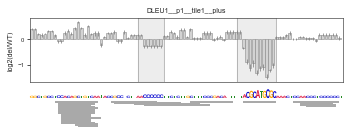

{'motif': ['Tcf21', 'TGIF1', 'TGIF1', 'Tcf12', 'Myog', 'TGIF2', 'ZBTB18', 'PKNOX2', 'PKNOX1', 'TGIF2', 'PKNOX1', 'Ascl2', 'ID4', 'NHLH1', 'TFAP4', 'Myod1', 'MYF6', 'MSC', 'Ascl2', 'TFAP4', 'Tcf12', 'MEIS2', 'MEIS3', 'MEIS1', 'NR2C2', 'ZNF263', 'ZNF263', 'ZNF263', 'E2F7', 'NRF1', 'NR2C2', 'KLF16', 'SP3', 'SP8', 'ZNF740'], 'start': [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 13, 14, 24, 25, 31, 34, 48, 64, 79, 81, 81, 81, 83], 'end': [20, 19, 19, 18, 18, 19, 20, 19, 19, 19, 19, 18, 18, 18, 18, 21, 18, 18, 18, 18, 19, 20, 20, 20, 38, 45, 51, 54, 61, 74, 93, 91, 91, 92, 92], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no pea

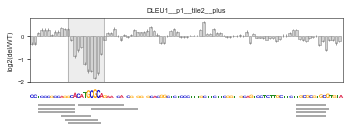

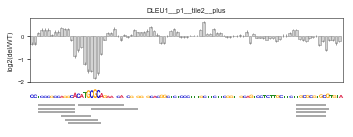

{'motif': ['TFAP2B', 'TFAP2A(var.2)', 'TFAP2C', 'Myc', 'NRF1', 'NRF1', 'MAF::NFE2', 'Nfe2l2', 'Hes1', 'NRF1', 'Tcfl5', 'Tcfl5'], 'start': [2, 2, 2, 9, 10, 11, 14, 18, 80, 80, 80, 80], 'end': [13, 13, 13, 18, 20, 21, 28, 32, 89, 90, 89, 89], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak']}
MEG3__p1__tile2__plus
[13, 13, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 20, 28, 28, 28, 32, 33, 56, 56, 57, 57, 57, 57, 97]
[23, 24, 32, 30, 30, 30, 30, 29, 27, 29, 29, 29, 29, 27, 27, 39, 39, 39, 46, 53, 66, 70, 66, 76, 66, 67, 107]


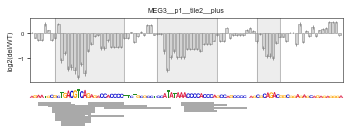

{'motif': ['NRL', 'Mafb', 'Gmeb1', 'ATF7', 'BATF3', 'ATF7', 'BATF3', 'Creb5', 'Crem', 'JDP2(var.2)', 'JDP2(var.2)', 'Creb5', 'Crem', 'CREB1', 'CREB1', 'ZBTB7C', 'GLI2', 'ZBTB7B', 'ZIC3', 'ZNF263', 'Klf1', 'Klf12', 'KLF5', 'RREB1', 'Klf4', 'SP3'], 'start': [2, 2, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 9, 9, 9, 17, 17, 17, 21, 22, 45, 45, 46, 46, 46, 46], 'end': [12, 13, 21, 19, 19, 19, 19, 18, 16, 18, 18, 18, 18, 16, 16, 28, 28, 28, 35, 42, 55, 59, 55, 65, 55, 56], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
CRNDE__p1__tile1__minus
[8, 32, 32, 60, 93, 96, 98, 98, 98, 98]
[18, 42, 42, 73, 104, 106, 107, 112, 107, 108]


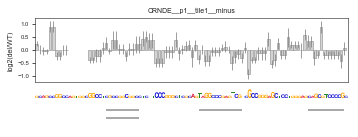

{'motif': ['TFAP2A', 'TFAP2B(var.2)', 'Zfx', 'HINFP'], 'start': [21, 21, 49, 82], 'end': [31, 31, 62, 93], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak']}
CRNDE__p1__tile2__minus
[1, 2, 4, 4, 4, 4, 6, 10, 11, 14, 18, 22, 22, 23, 24, 24, 41, 48, 55, 56, 56, 56, 56, 56, 57, 60, 60, 60, 60, 60, 60, 65, 83, 95]
[21, 12, 13, 18, 14, 13, 23, 27, 21, 34, 31, 32, 32, 43, 34, 38, 52, 61, 65, 66, 70, 66, 66, 69, 72, 70, 70, 70, 70, 70, 70, 81, 103, 106]


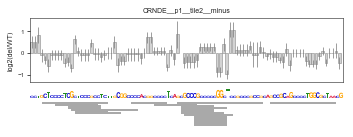

{'motif': ['ZNF263', 'EGR1', 'E2F6', 'E2F4', 'ZNF263', 'SP1', 'SP2', 'SP8', 'PLAG1', 'NRF1', 'KLF16', 'SP2', 'SP1', 'SP3', 'EGR1', 'EGR4', 'TFAP2C(var.2)', 'TFAP2B(var.2)', 'TFAP2B(var.2)', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2A', 'SP4', 'REST'], 'start': [3, 7, 11, 11, 12, 13, 13, 30, 37, 44, 45, 45, 45, 45, 45, 46, 49, 49, 49, 49, 49, 49, 54, 72], 'end': [23, 20, 21, 21, 32, 23, 27, 41, 50, 54, 55, 59, 55, 55, 58, 61, 59, 59, 59, 59, 59, 59, 70, 92], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
FENDRR__p1__tile2__minus
[1, 1, 6, 10, 11, 12, 12, 12, 17, 18, 20, 21, 21, 28, 28, 29, 29, 37, 38, 38, 38, 38, 38, 38, 40, 44, 52, 55, 56, 58, 61, 61, 62, 62, 62, 62]
[11, 12, 20, 20, 20, 22, 22, 25, 26, 27, 31, 31, 31, 43, 41, 44, 43, 49, 50, 50, 50, 50, 50, 50, 5

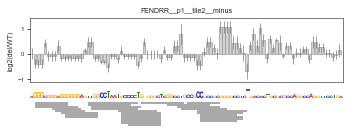

{'motif': ['E2F6', 'E2F4', 'PLAG1', 'MZF1(var.2)', 'ZNF740', 'SP8', 'KLF16', 'SP3', 'Rarg', 'NFIC::TLX1', 'Rarb', 'Nr2f6(var.2)', 'TFAP2A(var.3)', 'TFAP2B(var.3)', 'TFAP2B(var.3)', 'TFAP2A(var.3)', 'TFAP2C(var.3)', 'TFAP2A(var.3)', 'TFAP2C(var.3)', 'RUNX1', 'Zfx', 'EGR1', 'EGR1', 'EGR3', 'EGR2', 'GLIS1', 'ZIC4', 'TFAP2A(var.2)', 'ZIC1', 'Zfx', 'TFAP2A(var.2)'], 'start': [1, 1, 1, 6, 7, 9, 10, 10, 17, 17, 18, 18, 26, 27, 27, 27, 27, 27, 27, 29, 33, 41, 44, 45, 47, 50, 50, 51, 51, 51, 51], 'end': [11, 11, 14, 15, 16, 20, 20, 20, 32, 30, 33, 32, 38, 39, 39, 39, 39, 39, 39, 39, 46, 54, 57, 59, 57, 65, 64, 62, 64, 64, 62], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
FOXF1__p__tile1

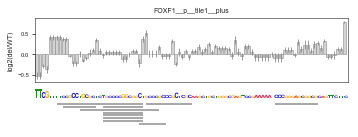

{'motif': ['EGR3', 'EGR2', 'Pparg::Rxra', 'TFAP2A(var.3)', 'TFAP2C(var.3)', 'TFAP2B(var.3)', 'TFAP2B(var.3)', 'TFAP2A(var.3)', 'TFAP2C(var.3)', 'NRF1', 'THAP1', 'EGR3', 'EGR1'], 'start': [6, 8, 13, 20, 20, 20, 20, 20, 20, 27, 31, 33, 72], 'end': [20, 18, 27, 32, 32, 32, 32, 32, 32, 37, 39, 47, 85], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
FOXF1__p__tile2__plus
[8, 12, 12, 13, 13, 14, 23, 24, 25, 35, 38, 41, 41]
[22, 22, 22, 22, 22, 24, 38, 38, 39, 49, 52, 51, 51]


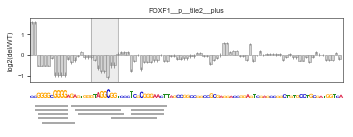

{'motif': ['SP1', 'SP3', 'KLF5', 'Klf4', 'E2F4', 'EGR4', 'EGR3', 'SP2', 'ZBTB33', 'ZBTB33', 'E2F4', 'E2F6'], 'start': [1, 1, 2, 2, 3, 12, 13, 14, 24, 27, 30, 30], 'end': [11, 11, 11, 11, 13, 27, 27, 28, 38, 41, 40, 40], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak']}
ZFAS1__p1__tile1__plus
[2, 5, 33, 33, 33, 33, 33, 33, 61, 62, 62, 87, 87]
[11, 18, 43, 43, 43, 43, 43, 43, 71, 72, 75, 97, 97]


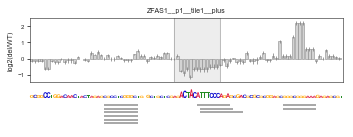

{'motif': ['TFAP2B(var.2)', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2A', 'TFAP2C(var.2)', 'TFAP2B(var.2)', 'Stat5a::Stat5b', 'STAT1', 'Rfx1', 'E2F4', 'E2F6'], 'start': [22, 22, 22, 22, 22, 22, 50, 51, 51, 76, 76], 'end': [32, 32, 32, 32, 32, 32, 60, 61, 64, 86, 86], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak']}
ZFAS1__p1__tile2__plus
[22, 23, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 34, 45, 46, 46, 46, 46]
[32, 33, 33, 32, 33, 33, 33, 33, 38, 36, 34, 35, 34, 34, 34, 36, 34, 34, 45, 55, 57, 57, 57, 57]


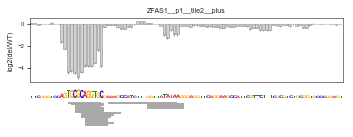

{'motif': ['NRF1', 'NRF1', 'TCF4', 'SNAI2', 'NHLH1', 'ID4', 'NHLH1', 'TCF3', 'EOMES', 'TBX2', 'ZEB1', 'TBX21', 'TBX5', 'MGA', 'TBX1', 'TBR1', 'TBX15', 'TBX4', 'YY1', 'NFIL3', 'DBP', 'DBP', 'TEF', 'HLF'], 'start': [11, 12, 13, 13, 13, 13, 13, 13, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 23, 34, 35, 35, 35, 35], 'end': [21, 22, 22, 21, 22, 22, 22, 22, 27, 25, 23, 24, 23, 23, 23, 25, 23, 23, 34, 44, 46, 46, 46, 46], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
TERC__p1__tile1__minus
[2, 26, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 30, 48, 53, 55, 57, 82, 85, 91, 98]
[12, 37, 37, 38, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 39, 44, 61, 64, 64, 76, 96, 99, 105, 112]


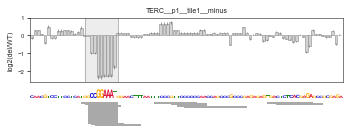

{'motif': ['ELF1', 'ETV2', 'ELK4', 'ETV6', 'ETV5', 'ETV4', 'ETV1', 'ELK1', 'ELK3', 'FEV', 'ETV3', 'ERF', 'ERG', 'FLI1', 'ETS1', 'Gabpa', 'STAT1::STAT2', 'PLAG1', 'E2F8', 'ZNF740', 'RREB1', 'ZBTB33', 'ZBTB33'], 'start': [15, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 19, 37, 42, 44, 46, 71, 74], 'end': [26, 26, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 28, 33, 50, 53, 53, 65, 85, 88], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
TERC__p1__tile2__minus
[4, 9, 14, 17, 41, 59, 72, 72, 73, 83, 87, 88, 88, 91, 93, 98, 98, 98, 99, 100, 100, 102, 102]
[18, 23, 28, 34, 55, 77, 86, 86, 86, 97, 97, 98, 97, 104, 107, 107, 108, 107, 110, 109, 110, 113, 113]


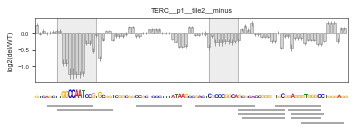

{'motif': ['NFYB', 'NFYA', 'TBP', 'PAX5', 'ZIC4', 'ZIC3', 'ZIC1', 'SP2', 'SP1', 'Klf1', 'Klf4', 'PLAG1'], 'start': [3, 6, 30, 48, 61, 61, 62, 72, 76, 77, 77, 80], 'end': [17, 23, 44, 66, 75, 75, 75, 86, 86, 87, 86, 93], 'peak_overlap': ['in peak', 'in peak', 'no peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
SAMMSON__p1__tile2__plus
[7, 7, 8, 25, 27, 27, 28, 29, 29, 29, 30, 30, 30, 30, 30, 34, 39, 49, 49, 49, 50, 53, 56, 56, 57, 59, 59, 60, 60, 60, 60, 62, 62, 62, 62, 63, 64, 64, 69, 77, 77, 87]
[16, 16, 14, 39, 37, 43, 45, 42, 43, 39, 40, 40, 41, 39, 39, 45, 52, 58, 58, 58, 64, 69, 67, 66, 75, 70, 70, 73, 74, 73, 74, 74, 74, 74, 74, 74, 74, 74, 82, 89, 85, 102]


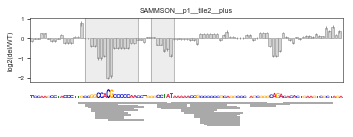

{'motif': ['EGR3', 'EGR2', 'SP4', 'KLF13', 'KLF14', 'Klf12', 'Klf1', 'SP3', 'KLF16', 'SP8', 'Klf4', 'KLF5', 'INSM1', 'Zfx', 'HOXB13', 'HOXA13', 'HOXD13', 'TBP', 'SP4', 'SP8', 'KLF16', 'CTCF', 'ZBTB7C', 'ZBTB7B', 'GLIS2', 'ZIC3', 'ZIC1', 'ZIC4', 'TFAP2C(var.3)', 'TFAP2C(var.3)', 'TFAP2A(var.3)', 'TFAP2B(var.3)', 'TFAP2A(var.2)', 'TFAP2A', 'TFAP2B(var.2)', 'Zfx', 'SMAD2::SMAD3::SMAD4', 'THAP1', 'SOX4'], 'start': [14, 16, 16, 17, 18, 18, 18, 19, 19, 19, 19, 19, 23, 28, 38, 38, 38, 39, 42, 45, 45, 46, 48, 48, 49, 49, 49, 49, 51, 51, 51, 51, 52, 53, 53, 58, 66, 66, 76], 'end': [28, 26, 32, 34, 31, 32, 28, 29, 29, 30, 28, 28, 34, 41, 47, 47, 47, 53, 58, 56, 55, 64, 59, 59, 62, 63, 62, 63, 63, 63, 63, 63, 63, 63, 63, 71, 78, 74, 91], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no 

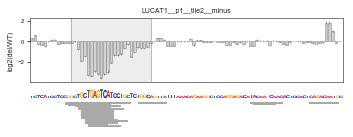

{'motif': ['MAFG', 'MAF::NFE2', 'JUN(var.2)', 'Bach1::Mafk', 'JUNB', 'Nfe2l2', 'NFE2', 'FOS', 'NFE2', 'FOSL1', 'JUND', 'JUND', 'FOSL1', 'FOS', 'JUNB', 'JUN(var.2)', 'JDP2', 'FOSL2', 'FOS::JUN', 'BATF::JUN', 'Myb', 'FOXH1', 'Dux', 'Sox6'], 'start': [10, 10, 11, 13, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 32, 66, 67, 84], 'end': [30, 24, 24, 27, 24, 28, 25, 25, 25, 25, 25, 25, 25, 25, 26, 29, 24, 26, 23, 27, 41, 76, 74, 93], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak']}
LINC_PINT__p2__tile1__minus
[1, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16, 19, 20, 31, 33, 34, 37, 49, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 84, 85]
[14, 17, 19, 20, 22, 23, 25, 26, 28, 28, 29, 32, 38, 45, 47, 48, 51, 61, 61, 61, 62, 62, 64, 61, 61, 61, 61, 61, 61, 94

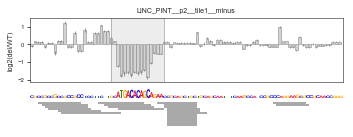

{'motif': ['EGR1', 'EGR3', 'Zfx', 'EGR1', 'EGR1', 'CTCF', 'Pou5f1::Sox2', 'Nfe2l2', 'Bach1::Mafk', 'MAF::NFE2', 'Myod1', 'Tcf12', 'Myog', 'Myog', 'Tcf12', 'Myod1', 'NHLH1', 'TCF4', 'TCF3', 'NHLH1', 'Ascl2', 'Ascl2', 'ELK4', 'Gabpa'], 'start': [2, 3, 4, 5, 8, 9, 20, 22, 23, 26, 38, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 73, 74], 'end': [15, 17, 17, 18, 21, 27, 34, 36, 37, 40, 50, 50, 50, 51, 51, 53, 50, 50, 50, 50, 50, 50, 83, 84], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
PVT1__p1__tile1__plus
[2, 13, 14, 20, 27, 29, 43, 69, 69, 69, 69, 69, 86, 86, 87, 88, 88, 88, 90, 97, 98, 98, 98, 100, 100, 100, 100, 100, 100, 101]
[15, 27, 27, 34, 37, 40, 56, 78, 78, 78, 78, 78, 95, 95, 97, 97, 97, 97, 104, 106, 112, 107, 112, 114, 109, 110, 110, 109, 110, 1

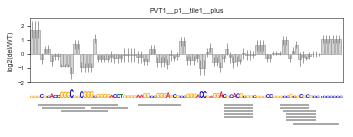

{'motif': ['ZIC4', 'ZIC1', 'ZIC4', 'E2F4', 'HINFP', 'Zfx', 'Tcfl5', 'Tcfl5', 'HEY2', 'Hes1', 'HEY1', 'Tcfl5', 'Tcfl5', 'NRF1', 'Tcfl5', 'Tcfl5', 'Hes1', 'SP2'], 'start': [2, 3, 9, 16, 18, 32, 58, 58, 58, 58, 58, 75, 75, 76, 77, 77, 77, 79], 'end': [16, 16, 23, 26, 29, 45, 67, 67, 67, 67, 67, 84, 84, 86, 86, 86, 86, 93], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
PVT1__p1__tile2__plus
[3, 4, 4, 4, 6, 6, 6, 6, 6, 6, 7, 11, 11, 11, 11, 12, 12, 17, 25, 25, 34, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 39, 39, 39, 40, 42, 42, 42, 48, 55, 58, 73, 98]
[12, 13, 18, 18, 16, 20, 15, 16, 16, 15, 16, 22, 22, 22, 22, 22, 22, 30, 34, 34, 48, 51, 47, 49, 49, 49, 49, 49, 49, 43, 46, 48, 48, 48, 48, 45, 46, 46, 48, 47, 49, 51, 51, 61, 75, 74, 81, 107]


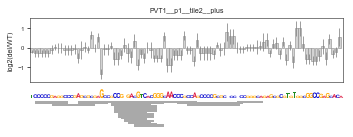

{'motif': ['TFAP2A', 'TFAP2B(var.2)', 'Zfx', 'Tcfl5', 'Tcfl5', 'JUND(var.2)', 'Gmeb1', 'JUN', 'BATF3', 'BATF3', 'CREB3', 'CREB3', 'ATF7', 'ATF7', 'Pax2', 'Crem', 'Creb5', 'JDP2(var.2)', 'JDP2(var.2)', 'Creb5', 'Atf1', 'CREB1', 'CREB1', 'Crem', 'Atf1', 'Pax2', 'Mitf', 'Arntl', 'NFIC::TLX1', 'ZNF263', 'SP4', 'THAP1'], 'start': [1, 1, 6, 14, 14, 23, 24, 24, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 28, 28, 28, 29, 31, 31, 31, 37, 44, 47, 62], 'end': [11, 11, 19, 23, 23, 37, 40, 36, 38, 38, 38, 38, 38, 38, 32, 35, 37, 37, 37, 37, 34, 35, 35, 37, 36, 38, 40, 40, 50, 64, 63, 70], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
CDKN2A__p1__tile1__minus
[12, 15, 16, 1

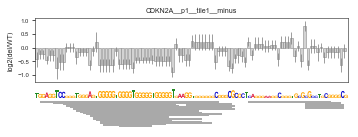

{'motif': ['ZNF263', 'RREB1', 'EGR4', 'RREB1', 'RREB1', 'PLAG1', 'SP2', 'RREB1', 'RREB1', 'EGR1', 'SP8', 'KLF16', 'SP3', 'RREB1', 'EGR3', 'KLF5', 'RREB1', 'Klf1', 'ZNF263', 'EGR3', 'RREB1', 'SP4', 'RREB1', 'SP2', 'RREB1', 'SP4', 'EGR1', 'SP8', 'PLAG1', 'KLF16', 'ZNF740', 'SP3', 'RREB1', 'SP8', 'RREB1', 'KLF16', 'RREB1', 'ZNF263', 'SP3', 'SP1', 'Klf4', 'KLF5', 'RREB1', 'SP2', 'Klf1', 'RREB1', 'EGR4', 'RREB1', 'EGR3', 'RREB1', 'ZNF740', 'SP3', 'SP1', 'ZNF263', 'EGR3', 'Klf4', 'KLF5', 'Klf1', 'ZNF263', 'SP2', 'SP8', 'EGR1', 'KLF16', 'ZNF740', 'SP3', 'EGR4', 'SP8', 'NR2C2', 'EGR3', 'ZNF263', 'SP1', 'SP3', 'KLF16', 'Klf4', 'Klf1', 'KLF5', 'RREB1', 'RREB1', 'EGR1', 'EWSR1-FLI1', 'RREB1', 'ZNF263', 'RREB1', 'ZNF740', 'NR2C2', 'ZNF263', 'PLAG1', 'NR2C2', 'SP2', 'EGR1', 'GLIS2', 'SP1', 'SP2', 'ZNF740', 'ZNF740', 'KLF14', 'SP1', 'KLF16', 'SP3', 'NRF1', 'SP2', 'NRF1', 'NRF1', 'TFAP2A', 'TFAP2A(var.2)', 'TFAP2C(var.2)', 'TFAP2B(var.3)', 'TFAP2C(var.3)', 'TFAP2A', 'TFAP2A(var.3)', 'TFAP2B(var.2)', 

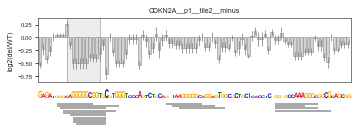

{'motif': ['INSM1', 'RREB1', 'SP2', 'SP4', 'EGR1', 'SP8', 'SP3', 'SP1', 'KLF16', 'Klf4', 'INSM1', 'EGR1', 'NR2C2', 'Nr2f6', 'NFIA', 'PLAG1', 'NFIX', 'Klf4'], 'start': [5, 5, 6, 7, 7, 9, 10, 10, 10, 11, 38, 40, 42, 71, 71, 71, 71, 79], 'end': [16, 24, 20, 23, 20, 20, 20, 20, 20, 20, 49, 53, 56, 84, 80, 84, 79, 88], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
ANRIL__p1__tile2__plus
[3, 4, 8, 9, 9, 9, 66, 66, 83, 83, 83, 84, 84, 84, 84, 84, 84]
[13, 14, 23, 23, 22, 23, 79, 77, 94, 93, 93, 93, 93, 93, 93, 93, 93]


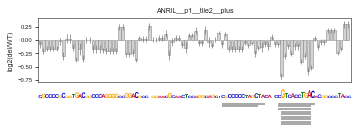

{'motif': ['Rfx1', 'INSM1', 'PKNOX2', 'USF2', 'USF1', 'Srebf1(var.2)', 'SREBF2(var.2)', 'SREBF1', 'TFEC', 'Srebf1(var.2)', 'SREBF2(var.2)'], 'start': [55, 55, 72, 72, 72, 73, 73, 73, 73, 73, 73], 'end': [68, 66, 83, 82, 82, 82, 82, 82, 82, 82, 82], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
JPX__p1__tile1__plus
[54, 54, 82]
[67, 67, 91]


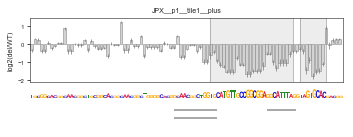

{'motif': ['Tcf21', 'Tcf21', 'Barhl1'], 'start': [43, 43, 71], 'end': [56, 56, 80], 'peak_overlap': ['in peak', 'in peak', 'in peak']}
JPX__p1__tile2__plus
[13, 33, 35, 35, 36, 37, 37, 38, 38, 38, 38, 39, 48, 65, 65, 65, 65, 65, 65, 88, 90]
[26, 46, 49, 50, 47, 48, 48, 51, 48, 48, 52, 53, 61, 76, 76, 76, 76, 76, 76, 99, 100]


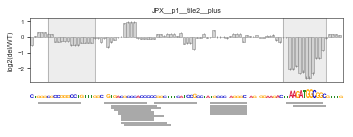

{'motif': ['Zfx', 'KLF14', 'EGR3', 'EGR4', 'ZBTB7A', 'ZBTB7B', 'ZBTB7C', 'EGR1', 'SP1', 'KLF16', 'SP2', 'ZIC3', 'TCF7L2', 'TFAP2A(var.2)', 'TFAP2B', 'TFAP2C', 'TFAP2C', 'TFAP2A(var.2)', 'TFAP2B', 'YY1', 'YY2'], 'start': [2, 22, 24, 24, 25, 26, 26, 27, 27, 27, 27, 28, 37, 54, 54, 54, 54, 54, 54, 77, 79], 'end': [15, 35, 38, 39, 36, 37, 37, 40, 37, 37, 41, 42, 50, 65, 65, 65, 65, 65, 65, 88, 89], 'peak_overlap': ['in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak']}
CRNDE__p1__tile1__plus
[9, 12, 34, 43, 45, 45, 45, 45, 45, 45, 45, 46, 49, 49, 49, 50, 54, 63, 72, 77, 81, 81, 83, 83, 84, 88, 92, 94, 94, 97, 101, 102, 102, 103]
[20, 32, 50, 58, 55, 59, 55, 55, 55, 55, 55, 59, 59, 59, 59, 60, 67, 74, 92, 91, 91, 101, 93, 93, 97, 105, 109, 114, 104, 111, 111, 111, 111, 113]


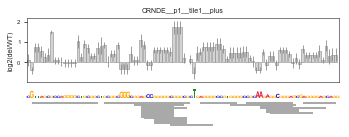

{'motif': ['REST', 'SP4', 'EGR4', 'TFAP2B(var.2)', 'SP2', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2B(var.2)', 'EGR1', 'KLF16', 'SP1', 'SP3', 'NRF1', 'PLAG1', 'SP8', 'ZNF263', 'SP2', 'SP1', 'ZNF263', 'E2F4', 'E2F6', 'EGR1', 'Spz1'], 'start': [1, 23, 32, 34, 34, 34, 34, 34, 34, 34, 35, 38, 38, 38, 39, 43, 52, 61, 66, 70, 70, 72, 72, 73, 83], 'end': [21, 39, 47, 44, 48, 44, 44, 44, 44, 44, 48, 48, 48, 48, 49, 56, 63, 81, 80, 80, 90, 82, 82, 86, 93], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
CRNDE__p1__tile2__plus
[3, 7, 8, 8, 9, 11, 42, 73, 73, 97]
[17, 17, 17, 17, 19, 22, 55, 83, 83, 107]


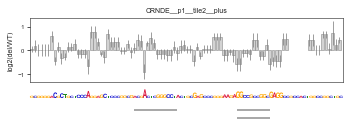

{'motif': ['Zfx', 'TFAP2A', 'TFAP2B(var.2)'], 'start': [31, 62, 62], 'end': [44, 72, 72], 'peak_overlap': ['no peak', 'no peak', 'no peak']}
FENDRR__p1__tile1__plus
[39, 40, 40, 40, 42, 42, 45, 47, 47, 50, 58, 65, 65, 65, 65, 65, 65, 65, 66, 71, 72, 72, 74, 84, 84, 84, 88, 89, 90, 93, 93, 95, 95, 95, 103, 104]
[54, 54, 53, 53, 53, 53, 59, 57, 60, 63, 71, 77, 75, 77, 77, 77, 77, 77, 78, 86, 86, 87, 87, 94, 94, 95, 97, 98, 103, 103, 103, 105, 109, 104, 114, 114]


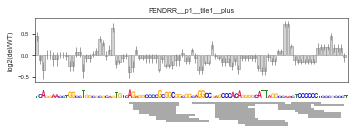

{'motif': ['GLIS1', 'ZIC4', 'Zfx', 'ZIC1', 'TFAP2A(var.2)', 'TFAP2A(var.2)', 'EGR3', 'EGR2', 'EGR1', 'EGR1', 'Zfx', 'TFAP2B(var.3)', 'RUNX1', 'TFAP2B(var.3)', 'TFAP2A(var.3)', 'TFAP2C(var.3)', 'TFAP2C(var.3)', 'TFAP2A(var.3)', 'TFAP2A(var.3)', 'Rarb', 'Nr2f6(var.2)', 'Rarg', 'NFIC::TLX1', 'KLF16', 'SP3', 'SP8', 'ZNF740', 'MZF1(var.2)', 'PLAG1', 'E2F4', 'E2F6', 'KLF5'], 'start': [28, 29, 29, 29, 31, 31, 34, 36, 36, 39, 47, 54, 54, 54, 54, 54, 54, 54, 55, 60, 61, 61, 63, 73, 73, 73, 77, 78, 79, 82, 82, 84], 'end': [43, 43, 42, 42, 42, 42, 48, 46, 49, 52, 60, 66, 64, 66, 66, 66, 66, 66, 67, 75, 75, 76, 76, 83, 83, 84, 86, 87, 92, 92, 92, 93], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no p

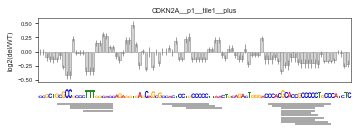

{'motif': ['Klf4', 'PLAG1', 'Nr2f6', 'NFIA', 'NFIX', 'NR2C2', 'EGR1', 'INSM1', 'RREB1', 'SP4', 'SP3', 'KLF16', 'Klf4', 'SP8', 'EGR1', 'SP1', 'SP2', 'INSM1'], 'start': [5, 9, 9, 13, 14, 37, 40, 44, 69, 70, 73, 73, 73, 73, 73, 73, 73, 77], 'end': [14, 22, 22, 22, 22, 51, 53, 55, 88, 86, 83, 83, 82, 84, 86, 83, 87, 88], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
CDKN2A__p1__tile2__plus
[7, 7, 7, 11, 11, 11, 11, 11, 11, 12, 13, 13, 13, 13, 15, 22, 26, 44, 44, 45, 45, 45, 45, 48, 49, 49, 50, 51, 51, 52, 52, 52, 52, 53, 54, 54, 54, 54, 55, 55, 58, 58, 60, 61, 61, 61, 61, 62, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 68, 69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 72, 72, 73, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 77, 77, 77, 77, 78, 78, 79, 81, 81, 81, 82, 82,

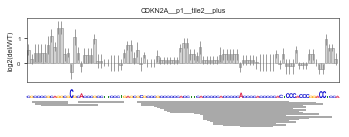

{'motif': ['TFAP2A(var.2)', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2B(var.2)', 'TFAP2A', 'NRF1', 'NRF1', 'SP2', 'NRF1', 'KLF14', 'SP1', 'KLF16', 'SP2', 'SP3', 'ZNF263', 'GLIS2', 'ZNF740', 'ZNF740', 'RREB1', 'ZNF263', 'RREB1', 'EGR1', 'SP2', 'SP1', 'RREB1', 'ZNF263', 'RREB1', 'NR2C2', 'EWSR1-FLI1', 'PLAG1', 'NR2C2', 'EGR1', 'ZNF263', 'ZNF263', 'EGR3', 'EGR4', 'ZNF740', 'NR2C2', 'RREB1', 'RREB1', 'Klf1', 'Klf4', 'SP3', 'SP1', 'SP8', 'KLF16', 'RREB1', 'EGR1', 'KLF5', 'SP2', 'ZNF263', 'EGR3', 'RREB1', 'SP8', 'SP3', 'RREB1', 'KLF16', 'EGR3', 'ZNF740', 'RREB1', 'EGR4', 'RREB1', 'Klf1', 'RREB1', 'KLF5', 'SP1', 'SP3', 'Klf4', 'SP2', 'RREB1', 'RREB1', 'ZNF263', 'SP4', 'ZNF740', 'RREB1', 'PLAG1', 'SP4', 'RREB1', 'Klf1', 'SP1', 'EGR1', 'KLF16', 'SP8', 'KLF5', 'SP2', 'RREB1', 'Klf4', 'SP3', 'RREB1', 'EGR3', 'SP3', 'RREB1', 'KLF16', 'SP8', 'EGR3', 'ZNF740', 'RREB1', 'RREB1', 'EGR1', 'SP2', 'PLAG1', 'Klf1', 'SP3', 'SP8', 'ZNF263', 'KLF16', 'KLF5', 'EGR4'], 'start': [1, 2, 2, 2, 2, 4, 11, 15, 33, 33, 34, 34

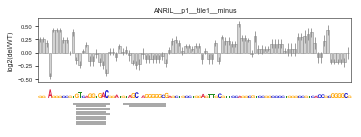

{'motif': ['PKNOX2', 'SREBF2(var.2)', 'USF1', 'TFEC', 'USF2', 'Srebf1(var.2)', 'SREBF2(var.2)', 'Srebf1(var.2)', 'SREBF1', 'Rfx1', 'INSM1'], 'start': [10, 11, 11, 11, 11, 11, 11, 11, 11, 25, 27], 'end': [21, 20, 21, 20, 21, 20, 20, 20, 20, 38, 38], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
ANRIL__p1__tile2__minus
[7, 8, 14, 15, 19, 20, 21, 25, 26, 27, 27, 28, 29, 30, 30, 31, 32, 35, 36, 36, 37, 37, 37, 38, 39, 39, 39, 40, 40, 40, 52, 56, 57, 58, 58, 70, 73, 74, 74, 76, 76, 80, 80, 81, 87]
[17, 18, 28, 29, 29, 29, 31, 44, 46, 38, 47, 47, 48, 49, 50, 50, 51, 49, 49, 47, 47, 46, 47, 49, 49, 49, 49, 49, 49, 50, 66, 66, 66, 68, 68, 84, 90, 84, 85, 86, 86, 94, 90, 94, 93]


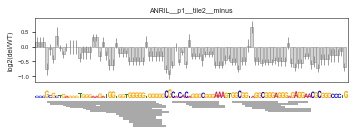

{'motif': ['ZIC3', 'SP2', 'SP1', 'KLF5', 'E2F6', 'RREB1', 'ZNF263', 'YY1', 'ZNF263', 'RREB1', 'RREB1', 'RREB1', 'ZNF263', 'RREB1', 'RREB1', 'SP2', 'EGR1', 'SP8', 'KLF16', 'ZNF740', 'SP3', 'SP8', 'KLF16', 'SP3', 'SP1', 'Klf4', 'KLF5', 'Klf1', 'SP2', 'SP1', 'KLF5', 'E2F4', 'E2F6', 'SP2', 'EWSR1-FLI1', 'SP1', 'E2F8', 'E2F6', 'E2F4', 'SP2', 'E2F6', 'EGR1', 'SPIB'], 'start': [3, 4, 8, 9, 10, 14, 15, 16, 16, 17, 18, 19, 19, 20, 21, 24, 25, 25, 26, 26, 26, 27, 28, 28, 28, 29, 29, 29, 41, 45, 46, 47, 47, 59, 62, 63, 63, 65, 65, 69, 69, 70, 76], 'end': [17, 18, 18, 18, 20, 33, 35, 27, 36, 36, 37, 38, 39, 39, 40, 38, 38, 36, 36, 35, 36, 38, 38, 38, 38, 38, 38, 39, 55, 55, 55, 57, 57, 73, 79, 73, 74, 75, 75, 83, 79, 83, 82], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no pe

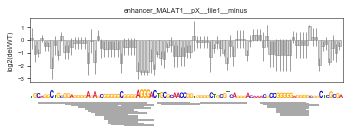

{'motif': ['Zfx', 'MZF1(var.2)', 'SP2', 'ZNF263', 'ZNF263', 'ZNF263', 'EGR4', 'EGR3', 'SP2', 'EGR1', 'SP4', 'EGR2', 'KLF16', 'SP1', 'SP3', 'SP2', 'Klf4', 'KLF5', 'E2F4', 'SP1', 'KLF5', 'NRF1', 'SCRT2', 'Bach1::Mafk', 'ZIC3', 'SP2', 'SP4', 'EGR1', 'SP1', 'ZNF740', 'SP3', 'KLF16', 'Klf4', 'KLF5'], 'start': [2, 10, 12, 14, 15, 16, 16, 17, 18, 19, 19, 19, 22, 22, 22, 23, 23, 23, 24, 27, 28, 38, 39, 51, 69, 70, 71, 71, 74, 74, 74, 74, 75, 75], 'end': [15, 19, 26, 34, 35, 36, 31, 31, 32, 32, 35, 29, 32, 32, 32, 37, 32, 32, 34, 37, 37, 48, 51, 65, 83, 84, 87, 84, 84, 83, 84, 84, 84, 84], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
enhancer_MALAT1__pX_

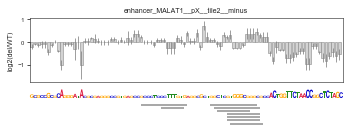

{'motif': ['ZIC3', 'Sox2', 'EGR3', 'SP2', 'EGR2', 'SP1', 'SP3', 'KLF16', 'NRF1'], 'start': [33, 39, 54, 55, 56, 59, 59, 59, 60], 'end': [47, 46, 68, 69, 66, 69, 69, 69, 70], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
FALEC__p1__tile2__plus
[4, 32, 36, 43, 44, 45, 47, 49, 68, 88, 91, 91, 92, 94, 96, 99, 102]
[12, 46, 50, 53, 54, 54, 61, 58, 81, 94, 111, 108, 106, 107, 110, 112, 113]


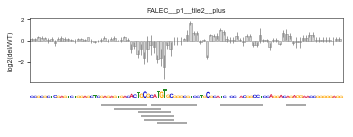

{'motif': ['Nfe2l2', 'MAF::NFE2', 'NRF1', 'NRF1', 'NHLH1', 'EGR3', 'GCM2', 'PLAG1', 'SPIB'], 'start': [21, 25, 32, 33, 34, 36, 38, 57, 77], 'end': [35, 39, 42, 43, 43, 50, 47, 70, 83], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
GAS5__p1__tile1__minus
[2, 3, 3, 4, 6, 7, 8, 8, 9, 11, 11, 16, 18, 29, 33, 34, 35, 35, 56, 61, 68, 71, 72, 74, 75, 78, 79, 80, 80, 81, 82, 83, 83, 84, 96]
[22, 23, 17, 20, 26, 17, 17, 17, 19, 24, 25, 30, 31, 43, 43, 43, 45, 51, 76, 67, 88, 91, 92, 87, 89, 89, 93, 96, 89, 94, 93, 93, 93, 93, 107]


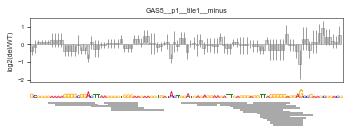

{'motif': ['SP2', 'KLF14', 'SP2', 'SP1', 'KLF5', 'E2F6', 'RARA::RXRA', 'ZNF263', 'SPIB', 'ZNF263', 'ZNF263', 'ZNF263', 'PLAG1', 'NR2C2', 'INSM1', 'SP2', 'SP4', 'MZF1(var.2)', 'KLF14', 'SP8', 'SP1', 'KLF16', 'KLF5'], 'start': [5, 7, 18, 22, 23, 24, 24, 45, 50, 57, 60, 61, 63, 64, 67, 68, 69, 69, 70, 71, 72, 72, 73], 'end': [19, 20, 32, 32, 32, 34, 40, 65, 56, 77, 80, 81, 76, 78, 78, 82, 85, 78, 83, 82, 82, 82, 82], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
GAS5__p1__tile2__minus
[2, 25, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29, 30, 30, 30, 32]
[13, 39, 38, 40, 40, 40, 40, 40, 39, 37, 39, 42, 39, 39, 41, 42, 36, 37, 37, 39, 39]


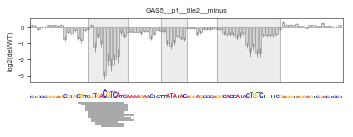

{'motif': ['JUND(var.2)', 'JUN', 'BATF3', 'BATF3', 'ATF7', 'ATF7', 'CREB3', 'JDP2(var.2)', 'Crem', 'Creb5', 'JUND(var.2)', 'JDP2(var.2)', 'Creb5', 'JUN', 'MTF1', 'Atf1', 'CREB1', 'CREB1', 'Crem', 'Atf3'], 'start': [14, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 21], 'end': [28, 27, 29, 29, 29, 29, 29, 28, 26, 28, 31, 28, 28, 30, 31, 25, 26, 26, 28, 28], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
ZBTB37__p1__tile2__plus
[2, 8, 9, 9, 10, 10, 10, 10, 10, 17, 18, 29, 29, 30, 30, 30, 30, 31, 31, 34, 34, 34, 34, 35, 35, 35, 36, 37, 37, 38, 38, 38, 39, 40, 40, 40, 41, 41, 46, 46, 47, 48, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 91, 91]
[11, 18, 21, 19, 19, 19, 19, 19, 19, 26, 25, 43, 43, 43, 44, 43, 43, 44, 41, 44, 43, 44, 44, 54, 44,

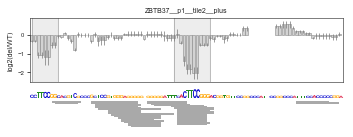

{'motif': ['HEY2', 'ARNT::HIF1A', 'ZIC3', 'ZIC4', 'ZIC1', 'SP2', 'GLIS3', 'GLIS2', 'EGR1', 'EGR2', 'KLF16', 'ZNF740', 'SP1', 'SP3', 'RREB1', 'Klf4', 'KLF5', 'SP2', 'MZF1(var.2)', 'EGR1', 'SP3', 'ZNF740', 'PLAG1', 'SP8', 'SP3', 'SP1', 'KLF16', 'Klf4', 'KLF5', 'NFKB1', 'NFKB1', 'REL', 'Ddit3::Cebpa', 'Gabpa', 'ELK4', 'ELF3', 'ELF4', 'ELF5', 'ETV6', 'EHF', 'ELF1', 'ETS1', 'ETV3', 'ELK1', 'ERF', 'ELK3', 'ERG', 'ETV4', 'FLI1', 'ETV1', 'FEV', 'SPDEF', 'ETV5', 'SP1', 'EGR1'], 'start': [6, 7, 18, 18, 19, 19, 19, 19, 20, 20, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 27, 27, 28, 29, 29, 29, 30, 30, 35, 35, 36, 37, 42, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 80, 80], 'end': [15, 14, 32, 32, 32, 33, 32, 32, 33, 30, 33, 32, 33, 33, 43, 33, 33, 39, 35, 39, 37, 36, 40, 39, 39, 39, 39, 39, 39, 47, 47, 45, 48, 52, 53, 55, 55, 54, 53, 55, 55, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 53, 90, 93], 'peak_overlap': ['in peak', 'in peak', 'no peak', 'no peak', 'no pea

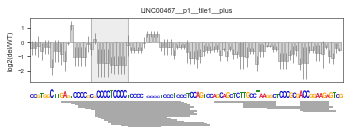

{'motif': ['SP4', 'PLAG1', 'KLF14', 'SP2', 'SP3', 'EWSR1-FLI1', 'KLF16', 'SP4', 'ZNF263', 'KLF5', 'SP3', 'Klf4', 'SP1', 'KLF16', 'SP8', 'ZNF263', 'SP2', 'ZNF263', 'ZNF263', 'ZNF263', 'MZF1(var.2)', 'EWSR1-FLI1', 'ZNF263', 'KLF16', 'ZNF263', 'SP1', 'SP2', 'KLF5', 'ZNF263', 'ZNF263', 'ZNF263', 'MZF1(var.2)', 'ZNF263', 'EWSR1-FLI1', 'KLF16', 'KLF5', 'ZNF263', 'SP2', 'SP1', 'EWSR1-FLI1', 'MZF1(var.2)', 'EWSR1-FLI1', 'KLF5', 'SP2', 'SP1', 'E2F6', 'EWSR1-FLI1', 'EWSR1-FLI1', 'SP1', 'KLF5', 'SP2', 'E2F6', 'MSC', 'TFAP2B(var.2)', 'TFAP2C(var.2)', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2A', 'TFAP2B(var.2)', 'E2F6', 'E2F4', 'ETV5', 'ELK1', 'ELK3', 'ERG', 'ETV1', 'ELK4', 'FEV', 'FLI1', 'ETS1', 'ETV4', 'Gabpa'], 'start': [9, 12, 13, 14, 14, 14, 14, 16, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 24, 24, 24, 25, 26, 27, 27, 28, 28, 29, 29, 29, 29, 29, 32, 32, 33, 34, 34, 34, 36, 36, 37, 38, 38, 38, 40, 55, 64, 64, 64, 64, 64, 64, 71, 71, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82],

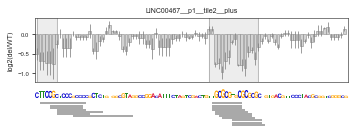

{'motif': ['EGR3', 'E2F4', 'E2F6', 'KLF5', 'SP2', 'SP1', 'PAX5', 'Hes1', 'Tcfl5', 'Tcfl5', 'NRF1', 'NRF1', 'HINFP', 'EGR2', 'NRF1', 'Tcfl5', 'Tcfl5', 'NRF1'], 'start': [1, 4, 4, 6, 6, 6, 11, 53, 53, 53, 53, 54, 54, 55, 56, 59, 59, 59], 'end': [15, 14, 14, 15, 20, 16, 29, 62, 62, 62, 63, 64, 65, 65, 66, 68, 68, 69], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
MALAT1__p1__tile2__plus
[13, 13, 14, 69, 77, 78, 82, 82, 82, 102, 102]
[24, 24, 28, 86, 91, 91, 102, 92, 98, 111, 110]


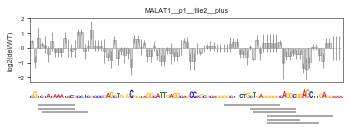

{'motif': ['MEF2B', 'MEF2D', 'TBP', 'MAFF', 'SP2', 'EGR1', 'ZNF263', 'NRF1', 'SP4'], 'start': [2, 2, 3, 58, 66, 67, 71, 71, 71], 'end': [13, 13, 17, 75, 80, 80, 91, 81, 87], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
DLEU1__p1__tile1__plus
[18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 24, 25, 35, 36, 42, 45, 59, 75, 88, 89, 90, 92, 92, 92, 92, 94, 96, 97, 99, 99, 99, 99, 104, 104]
[31, 30, 30, 29, 29, 30, 31, 30, 30, 30, 30, 29, 29, 29, 29, 32, 29, 29, 29, 29, 30, 31, 31, 31, 49, 56, 62, 65, 72, 85, 107, 109, 104, 106, 102, 102, 103, 103, 105, 106, 109, 109, 109, 113, 114, 114]


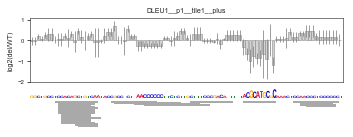

{'motif': ['Tcf21', 'TGIF1', 'TGIF1', 'Tcf12', 'Myog', 'TGIF2', 'ZBTB18', 'PKNOX2', 'PKNOX1', 'TGIF2', 'PKNOX1', 'Ascl2', 'ID4', 'NHLH1', 'TFAP4', 'Myod1', 'MYF6', 'MSC', 'Ascl2', 'TFAP4', 'Tcf12', 'MEIS2', 'MEIS3', 'MEIS1', 'NR2C2', 'ZNF263', 'ZNF263', 'ZNF263', 'E2F7', 'NRF1', 'NR2C2', 'KLF16', 'SP3', 'SP8', 'ZNF740'], 'start': [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 13, 14, 24, 25, 31, 34, 48, 64, 79, 81, 81, 81, 83], 'end': [20, 19, 19, 18, 18, 19, 20, 19, 19, 19, 19, 18, 18, 18, 18, 21, 18, 18, 18, 18, 19, 20, 20, 20, 38, 45, 51, 54, 61, 74, 93, 91, 91, 92, 92], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no pea

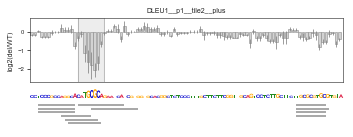

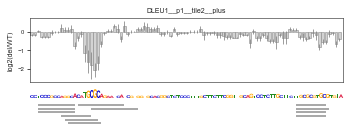

{'motif': ['TFAP2B', 'TFAP2A(var.2)', 'TFAP2C', 'Myc', 'NRF1', 'NRF1', 'MAF::NFE2', 'Nfe2l2', 'Hes1', 'NRF1', 'Tcfl5', 'Tcfl5'], 'start': [2, 2, 2, 9, 10, 11, 14, 18, 80, 80, 80, 80], 'end': [13, 13, 13, 18, 20, 21, 28, 32, 89, 90, 89, 89], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak']}
MEG3__p1__tile2__plus
[13, 13, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 20, 28, 28, 28, 32, 33, 56, 56, 57, 57, 57, 57, 97]
[23, 24, 32, 30, 30, 30, 30, 29, 27, 29, 29, 29, 29, 27, 27, 39, 39, 39, 46, 53, 66, 70, 66, 76, 66, 67, 107]


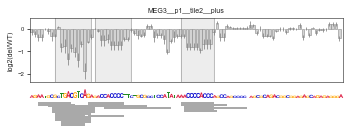

{'motif': ['NRL', 'Mafb', 'Gmeb1', 'ATF7', 'BATF3', 'ATF7', 'BATF3', 'Creb5', 'Crem', 'JDP2(var.2)', 'JDP2(var.2)', 'Creb5', 'Crem', 'CREB1', 'CREB1', 'ZBTB7C', 'GLI2', 'ZBTB7B', 'ZIC3', 'ZNF263', 'Klf1', 'Klf12', 'KLF5', 'RREB1', 'Klf4', 'SP3'], 'start': [2, 2, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 9, 9, 9, 17, 17, 17, 21, 22, 45, 45, 46, 46, 46, 46], 'end': [12, 13, 21, 19, 19, 19, 19, 18, 16, 18, 18, 18, 18, 16, 16, 28, 28, 28, 35, 42, 55, 59, 55, 65, 55, 56], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
FOXF1__p__tile2__plus
[8, 12, 12, 13, 13, 14, 23, 24, 25, 35, 38, 41, 41]
[22, 22, 22, 22, 22, 24, 38, 38, 39, 49, 52, 51, 51]


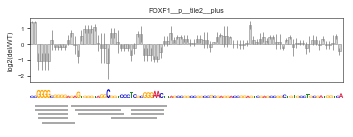

{'motif': ['SP1', 'SP3', 'KLF5', 'Klf4', 'E2F4', 'EGR4', 'EGR3', 'SP2', 'ZBTB33', 'ZBTB33', 'E2F4', 'E2F6'], 'start': [1, 1, 2, 2, 3, 12, 13, 14, 24, 27, 30, 30], 'end': [11, 11, 11, 11, 13, 27, 27, 28, 38, 41, 40, 40], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
ZFAS1__p1__tile1__plus
[2, 5, 33, 33, 33, 33, 33, 33, 61, 62, 62, 87, 87]
[11, 18, 43, 43, 43, 43, 43, 43, 71, 72, 75, 97, 97]


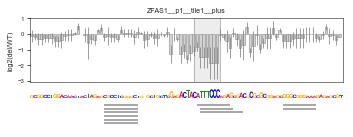

{'motif': ['TFAP2B(var.2)', 'TFAP2C(var.2)', 'TFAP2A', 'TFAP2A', 'TFAP2C(var.2)', 'TFAP2B(var.2)', 'Stat5a::Stat5b', 'STAT1', 'Rfx1', 'E2F4', 'E2F6'], 'start': [22, 22, 22, 22, 22, 22, 50, 51, 51, 76, 76], 'end': [32, 32, 32, 32, 32, 32, 60, 61, 64, 86, 86], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak']}
ZFAS1__p1__tile2__plus
[22, 23, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 34, 45, 46, 46, 46, 46]
[32, 33, 33, 32, 33, 33, 33, 33, 38, 36, 34, 35, 34, 34, 34, 36, 34, 34, 45, 55, 57, 57, 57, 57]


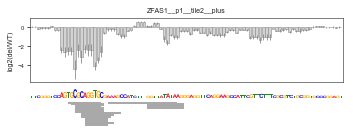

{'motif': ['NRF1', 'NRF1', 'TCF4', 'SNAI2', 'NHLH1', 'ID4', 'NHLH1', 'TCF3', 'EOMES', 'TBX2', 'ZEB1', 'TBX21', 'TBX5', 'MGA', 'TBX1', 'TBR1', 'TBX15', 'TBX4', 'YY1', 'NFIL3', 'DBP', 'DBP', 'TEF', 'HLF'], 'start': [11, 12, 13, 13, 13, 13, 13, 13, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 23, 34, 35, 35, 35, 35], 'end': [21, 22, 22, 21, 22, 22, 22, 22, 27, 25, 23, 24, 23, 23, 23, 25, 23, 23, 34, 44, 46, 46, 46, 46], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak']}
TERC__p1__tile1__minus
[2, 26, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 30, 48, 53, 55, 57, 82, 85, 91, 98]
[12, 37, 37, 38, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 39, 44, 61, 64, 64, 76, 96, 99, 105, 112]


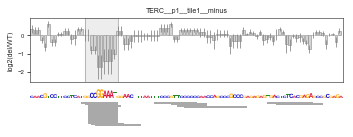

{'motif': ['ELF1', 'ETV2', 'ELK4', 'ETV6', 'ETV5', 'ETV4', 'ETV1', 'ELK1', 'ELK3', 'FEV', 'ETV3', 'ERF', 'ERG', 'FLI1', 'ETS1', 'Gabpa', 'STAT1::STAT2', 'PLAG1', 'E2F8', 'ZNF740', 'RREB1', 'ZBTB33', 'ZBTB33'], 'start': [15, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 19, 37, 42, 44, 46, 71, 74], 'end': [26, 26, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 28, 33, 50, 53, 53, 65, 85, 88], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
TERC__p1__tile2__minus
[4, 9, 14, 17, 41, 59, 72, 72, 73, 83, 87, 88, 88, 91, 93, 98, 98, 98, 99, 100, 100, 102, 102]
[18, 23, 28, 34, 55, 77, 86, 86, 86, 97, 97, 98, 97, 104, 107, 107, 108, 107, 110, 109, 110, 113, 113]


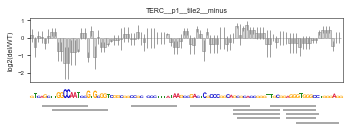

{'motif': ['NFYB', 'NFYA', 'TBP', 'PAX5', 'ZIC4', 'ZIC3', 'ZIC1', 'SP2', 'SP1', 'Klf1', 'Klf4', 'PLAG1'], 'start': [3, 6, 30, 48, 61, 61, 62, 72, 76, 77, 77, 80], 'end': [17, 23, 44, 66, 75, 75, 75, 86, 86, 87, 86, 93], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
SAMMSON__p1__tile2__plus
[7, 7, 8, 25, 27, 27, 28, 29, 29, 29, 30, 30, 30, 30, 30, 34, 39, 49, 49, 49, 50, 53, 56, 56, 57, 59, 59, 60, 60, 60, 60, 62, 62, 62, 62, 63, 64, 64, 69, 77, 77, 87]
[16, 16, 14, 39, 37, 43, 45, 42, 43, 39, 40, 40, 41, 39, 39, 45, 52, 58, 58, 58, 64, 69, 67, 66, 75, 70, 70, 73, 74, 73, 74, 74, 74, 74, 74, 74, 74, 74, 82, 89, 85, 102]


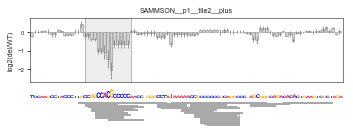

{'motif': ['EGR3', 'EGR2', 'SP4', 'KLF13', 'KLF14', 'Klf12', 'Klf1', 'SP3', 'KLF16', 'SP8', 'Klf4', 'KLF5', 'INSM1', 'Zfx', 'HOXB13', 'HOXA13', 'HOXD13', 'TBP', 'SP4', 'SP8', 'KLF16', 'CTCF', 'ZBTB7C', 'ZBTB7B', 'GLIS2', 'ZIC3', 'ZIC1', 'ZIC4', 'TFAP2C(var.3)', 'TFAP2C(var.3)', 'TFAP2A(var.3)', 'TFAP2B(var.3)', 'TFAP2A(var.2)', 'TFAP2A', 'TFAP2B(var.2)', 'Zfx', 'SMAD2::SMAD3::SMAD4', 'THAP1', 'SOX4'], 'start': [14, 16, 16, 17, 18, 18, 18, 19, 19, 19, 19, 19, 23, 28, 38, 38, 38, 39, 42, 45, 45, 46, 48, 48, 49, 49, 49, 49, 51, 51, 51, 51, 52, 53, 53, 58, 66, 66, 76], 'end': [28, 26, 32, 34, 31, 32, 28, 29, 29, 30, 28, 28, 34, 41, 47, 47, 47, 53, 58, 56, 55, 64, 59, 59, 62, 63, 62, 63, 63, 63, 63, 63, 63, 63, 63, 71, 78, 74, 91], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no 

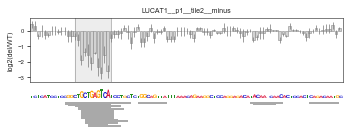

{'motif': ['MAFG', 'MAF::NFE2', 'JUN(var.2)', 'Bach1::Mafk', 'JUNB', 'Nfe2l2', 'NFE2', 'FOS', 'NFE2', 'FOSL1', 'JUND', 'JUND', 'FOSL1', 'FOS', 'JUNB', 'JUN(var.2)', 'JDP2', 'FOSL2', 'FOS::JUN', 'BATF::JUN', 'Myb', 'FOXH1', 'Dux', 'Sox6'], 'start': [10, 10, 11, 13, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 32, 66, 67, 84], 'end': [30, 24, 24, 27, 24, 28, 25, 25, 25, 25, 25, 25, 25, 25, 26, 29, 24, 26, 23, 27, 41, 76, 74, 93], 'peak_overlap': ['in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak']}
LINC_PINT__p2__tile1__minus
[1, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16, 19, 20, 31, 33, 34, 37, 49, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 84, 85]
[14, 17, 19, 20, 22, 23, 25, 26, 28, 28, 29, 32, 38, 45, 47, 48, 51, 61, 61, 61, 62, 62, 64, 61, 61, 61, 61, 61, 61, 94

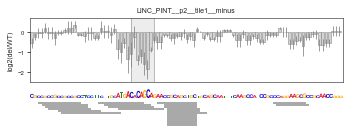

{'motif': ['EGR1', 'EGR3', 'Zfx', 'EGR1', 'EGR1', 'CTCF', 'Pou5f1::Sox2', 'Nfe2l2', 'Bach1::Mafk', 'MAF::NFE2', 'Myod1', 'Tcf12', 'Myog', 'Myog', 'Tcf12', 'Myod1', 'NHLH1', 'TCF4', 'TCF3', 'NHLH1', 'Ascl2', 'Ascl2', 'ELK4', 'Gabpa'], 'start': [2, 3, 4, 5, 8, 9, 20, 22, 23, 26, 38, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 73, 74], 'end': [15, 17, 17, 18, 21, 27, 34, 36, 37, 40, 50, 50, 50, 51, 51, 53, 50, 50, 50, 50, 50, 50, 83, 84], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak', 'in peak', 'in peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}
JPX__p1__tile1__plus
[54, 54, 82]
[67, 67, 91]


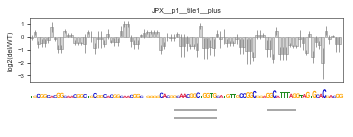

{'motif': ['Tcf21', 'Tcf21', 'Barhl1'], 'start': [43, 43, 71], 'end': [56, 56, 80], 'peak_overlap': ['no peak', 'no peak', 'no peak']}
JPX__p1__tile2__plus
[13, 33, 35, 35, 36, 37, 37, 38, 38, 38, 38, 39, 48, 65, 65, 65, 65, 65, 65, 88, 90]
[26, 46, 49, 50, 47, 48, 48, 51, 48, 48, 52, 53, 61, 76, 76, 76, 76, 76, 76, 99, 100]


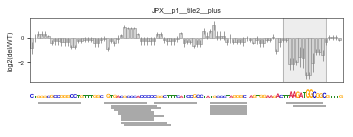

{'motif': ['Zfx', 'KLF14', 'EGR3', 'EGR4', 'ZBTB7A', 'ZBTB7B', 'ZBTB7C', 'EGR1', 'SP1', 'KLF16', 'SP2', 'ZIC3', 'TCF7L2', 'TFAP2A(var.2)', 'TFAP2B', 'TFAP2C', 'TFAP2C', 'TFAP2A(var.2)', 'TFAP2B', 'YY1', 'YY2'], 'start': [2, 22, 24, 24, 25, 26, 26, 27, 27, 27, 27, 28, 37, 54, 54, 54, 54, 54, 54, 77, 79], 'end': [15, 35, 38, 39, 36, 37, 37, 40, 37, 37, 41, 42, 50, 65, 65, 65, 65, 65, 65, 88, 89], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'in peak', 'in peak']}
ANRIL__p1__tile1__minus
[21, 22, 22, 22, 22, 22, 22, 22, 22, 36, 38, 92, 92, 92, 93, 101, 102]
[32, 31, 32, 31, 32, 31, 31, 31, 31, 49, 49, 106, 107, 106, 106, 111, 112]


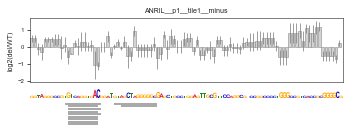

{'motif': ['PKNOX2', 'SREBF2(var.2)', 'USF1', 'TFEC', 'USF2', 'Srebf1(var.2)', 'SREBF2(var.2)', 'Srebf1(var.2)', 'SREBF1', 'Rfx1', 'INSM1'], 'start': [10, 11, 11, 11, 11, 11, 11, 11, 11, 25, 27], 'end': [21, 20, 21, 20, 21, 20, 20, 20, 20, 38, 38], 'peak_overlap': ['no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak', 'no peak']}


In [43]:
hepg2_motif_peaks = {}
k562_motif_peaks = {}

for data_peaks, data_motifs, cell in zip([hepg2_data_peaks, k562_data_peaks], [hepg2_motif_peaks, k562_motif_peaks],
                                         ["HepG2", "K562"]):
    print("")
    print(cell)
    for key in data_peaks:
        print(key)
        df = data_peaks[key]

        # put del_df bps in terms of 1-94
        df["delpos_fixed"] = list(range(1, 95))

        fimo_sub = fimo[(fimo["fixed_name"] == key) & (~fimo["unique_id"].str.contains("DELETION"))
                        & (~fimo["unique_id"].str.contains("SNP_INDIV"))]
        fimo_sub = fimo_sub.sort_values(by="start")
        #print(fimo_sub)
        scores = list(df["mean.log2FC"])
        yerrs = list(df["se"])
        scaled_scores = list(df["loss_score"])
        bases = list(df["seq"])
        motif_positions = list(zip(list(fimo_sub["start"]), list(fimo_sub["stop"]), list(fimo_sub["motif"])))
        print(list(fimo_sub["start"]))
        print(list(fimo_sub["stop"]))

        # get peak positions in tuples
        prev_p = "no peak"
        starts = []
        ends = []
        for i, p in zip(list(df["delpos_fixed"]), list(df["peak"])):
            if p == "peak" and prev_p == "no peak":
                starts.append(i-1)
            elif p == "no peak" and prev_p == "peak":
                ends.append(i-1)
            elif i == 94 and prev_p == "peak":
                ends.append(i)
            prev_p = p
        widths = list(zip(starts, ends))

        motif_positions_neg = [(x-del_buffer, y-del_buffer, m) for x, y, m in motif_positions]
        motif_positions_filt = [(x, y, m) for x, y, m in motif_positions_neg if x > 0 and y < seq_len]
        motif_positions_fixed = [(x, y) for x, y, m in motif_positions_filt]
        motif_names = [m for x, y, m in motif_positions_filt]


        if key == "MEG3__p1__tile2__plus":
            plot_peaks_and_fimo((5.6, 2), seq_len, key, widths, scores, yerrs, scaled_scores, bases, 
                                motif_positions_fixed, motif_names, "MEG3_%s.pdf" % cell, ".", True)
        elif key == "DLEU1__p1__tile2__plus":
            plot_peaks_and_fimo((5.6, 2), seq_len, key, widths, scores, yerrs, scaled_scores, bases, 
                                motif_positions_fixed, motif_names, "DLEU1_%s.pdf" % cell, ".", True)
            plot_peaks_and_fimo((5.6, 2), seq_len, key, [], scores, yerrs, scaled_scores, bases, 
                                motif_positions_fixed, motif_names, "DLEU1_%s.for_talk.pdf" % cell, ".", True)
        elif key == "ZFAS1__p1__tile2__plus":
            plot_peaks_and_fimo((5.6, 2), seq_len, key, [], scores, yerrs, scaled_scores, bases, 
                                motif_positions_fixed, motif_names, "ZFAS1_%s.for_talk.pdf" % cell, ".", True)
        else:
            plot_peaks_and_fimo((5.6, 2), seq_len, key, widths, scores, yerrs, scaled_scores, bases, 
                                motif_positions_fixed, motif_names, None, None, False)

        motifs = []
        starts = []
        ends = []
        in_peaks = []
        for start, end, motif in motif_positions_filt:
            motifs.append(motif)
            starts.append(start)
            ends.append(end)
            added = False
            for w in widths:
                overlap = getOverlap(w, [start, end])
                if overlap < 0:
                    in_peaks.append("in peak")
                    added = True
                    break
            if not added:
                in_peaks.append("no peak")
        data_motifs[key] = {"motif": motifs, "start": starts, "end": ends, "peak_overlap": in_peaks}
        print({"motif": motifs, "start": starts, "end": ends, "peak_overlap": in_peaks})

In [22]:
hepg2_motif_dfs = {}
k562_motif_dfs = {}

for data_motifs, dfs, cell in zip([hepg2_motif_peaks, k562_motif_peaks], [hepg2_motif_dfs, k562_motif_dfs], 
                                  ["HepG2", "K562"]):
    for key in data_motifs:
        data = data_motifs[key]
        df = pd.DataFrame.from_dict(data)
        df = df[["motif", "start", "end", "peak_overlap"]]
        df = df.drop_duplicates()
        dfs[key] = df
        
        # write file
        cell_dir = "%s/%s/1__motifs" % (out_dir, cell)
        !mkdir -p $cell_dir
        df = df.sort_values(by="start", ascending=True)
        df.to_csv("%s/%s.tfbs_peaks.txt" % (cell_dir, key), sep="\t", index=False)

hepg2_motif_dfs["GAS5__p1__tile2__minus"].head()

,motif,start,end,peak_overlap
0,JUND(var.2),14,28,in peak
1,JUN,15,27,in peak
2,BATF3,16,29,in peak
4,ATF7,16,29,in peak
6,CREB3,16,29,in peak


In [23]:
# find total # of tested motifs found to be in peaks
for motif_dfs, cell in zip([hepg2_motif_dfs, k562_motif_dfs], ["HepG2", "K562"]):
    print(cell)
    tot_motifs = 0
    tot_func_motifs = 0
    for key in motif_dfs:
        df = motif_dfs[key]
        tot_motifs += len(df)
        tot_func_motifs += len(df[df["peak_overlap"] == "in peak"])
    print("tot motifs: %s, tot func: %s, perc: %s" % (tot_motifs, tot_func_motifs, tot_func_motifs/tot_motifs))

HepG2
tot motifs: 1093, tot func: 314, perc: 0.28728270814272644
K562
tot motifs: 486, tot func: 189, perc: 0.3888888888888889


## 5. limit to TFs expressed in each cell line & in peaks

In [24]:
hepg2_motif_dfs_filt = {}
k562_motif_dfs_filt = {}

for motif_dfs, motif_dfs_filt, tfs in zip([hepg2_motif_dfs, k562_motif_dfs], 
                                          [hepg2_motif_dfs_filt, k562_motif_dfs_filt],
                                          [hepg2_tfs, k562_tfs]):
    for key in motif_dfs:
        df = motif_dfs[key]
        sub = df[(df["motif"].isin(tfs)) & (df["peak_overlap"] == "in peak")]
        motif_dfs_filt[key] = sub

hepg2_motif_dfs_filt["GAS5__p1__tile2__minus"].head()

,motif,start,end,peak_overlap
1,JUN,15,27,in peak
4,ATF7,16,29,in peak
6,CREB3,16,29,in peak
13,JUN,18,30,in peak
14,MTF1,18,31,in peak


## 6. make heatmap with TFs mapped in each sequence
note: use only HepG2 since there are more seqs expressed in HepG2 and use results filtered by TFs expr in HepG2

In [25]:
# first, put all gene data in dictionary of list of dataframes
hepg2_gene_data = {}
k562_gene_data = {}

for tile_data, gene_data in zip([hepg2_motif_dfs_filt, k562_motif_dfs_filt], [hepg2_gene_data, k562_gene_data]):
    for key in tile_data:
        data = tile_data[key]

        if "enhancer" not in key:
            gene_name = key.split("_")[0]
            prom_name = key.split("_")[1]
            tile_name = key.split("_")[2]
            strand_name = key.split("_")[3]
        else:
            gene_name = key.split("_")[0] + "_" + key.split("_")[1]
            prom_name = key.split("_")[2]
            tile_name = key.split("_")[3]
            strand_name = key.split("_")[4]

        data["gene_name"] = gene_name
        data["prom_name"] = prom_name
        data["tile_name"] = tile_name
        data["strand_name"] = strand_name

        if "LINC" in gene_name:
            if "00467" not in gene_name:
                if "enhancer" in gene_name:
                    gene_name = "enhancer_LINC-PINT"
                else:
                    gene_name = "LINC-PINT"
        if gene_name not in gene_data:
            gene_data[gene_name] = [data]
        else:
            current_gene_data = gene_data[gene_name]
            current_gene_data.append(data)

list(hepg2_gene_data.keys())[0:5]

['enhancer_NEAT1',
 'enhancer_MALAT1',
 'enhancer_TERC',
 'enhancer_LINC-PINT',
 'FALEC']

In [26]:
hepg2_sig_data = {}
k562_sig_data = {}

hepg2_all_motifs = []
k562_all_motifs = []

for sig_data, all_motifs, gene_data in zip([hepg2_sig_data, k562_sig_data], [hepg2_all_motifs, k562_all_motifs],
                                           [hepg2_gene_data, k562_gene_data]):
    for gene in gene_data:
        dfs = gene_data[gene]
        gene_motifs = []
        for df in dfs:
            gene_motifs.extend(list(df["motif"]))
        gene_motifs = list(set(gene_motifs))
        all_motifs.extend(gene_motifs)
        if len(gene_motifs) == 0:
            continue
        sig_data[gene] = gene_motifs

In [27]:
hepg2_all_motifs = list(set(hepg2_all_motifs))
len(hepg2_all_motifs)

79

In [28]:
hepg2_motif_idx_dict = {k:v for k, v in zip(hepg2_all_motifs, list(range(0, len(hepg2_all_motifs))))}

In [29]:
hepg2_motif_array = np.zeros((len(hepg2_sig_data), len(hepg2_all_motifs)))
for i, gene in enumerate(hepg2_sig_data):
    motif_data = hepg2_sig_data[gene]
    motif_idxs = [hepg2_motif_idx_dict[motif] for motif in motif_data]
    #print(gene)
    for j in motif_idxs:
        hepg2_motif_array[i, j] = 1

hepg2_mo_df = pd.DataFrame(hepg2_motif_array, index=list(hepg2_sig_data.keys()), columns=hepg2_all_motifs)
hepg2_mo_df.head()

,YY1,IRF1,NFYB,FOSL2,E2F6,ELF4,NFKB1,MEF2B,STAT3,JDP2,...,HINFP,MEF2D,SP4,ZNF263,EGR1,MEF2C,MEF2A,NR2C2,ZNF740,RREB1
enhancer_NEAT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
enhancer_LINC-PINT,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FALEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAS5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZBTB37,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [30]:
cmap = sns.light_palette("firebrick", reverse=False, as_cmap=True)

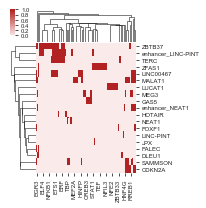

In [31]:
cg = sns.clustermap(hepg2_mo_df, annot=False, cmap=cmap, figsize=(2.25, 3))
cg.savefig("Fig_3D.pdf", bbox_inches="tight", dpi="figure")

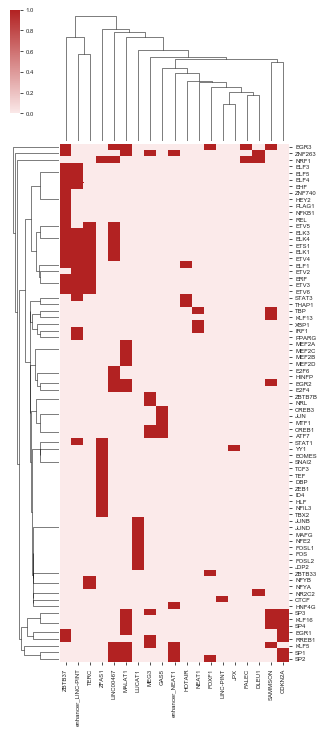

In [32]:
cg = sns.clustermap(hepg2_mo_df.T, annot=False, cmap=cmap, figsize=(5, 12))
cg.savefig("Fig_S10.pdf", bbox_inches="tight", dpi="figure")

## 7. plot number of motifs found in seqs expressed in only one cell type vs. two

In [33]:
expr_in_hepg2_not_k562 = [x for x in hepg2_gene_data.keys() if x not in k562_gene_data.keys()]
expr_in_both = [x for x in hepg2_gene_data.keys() if x in k562_gene_data.keys()]
expr_in_hepg2_not_k562

['enhancer_NEAT1',
 'enhancer_TERC',
 'enhancer_LINC-PINT',
 'NEAT1',
 'HOTAIR',
 'CRNDE',
 'FENDRR',
 'PVT1',
 'CDKN2A']

In [34]:
hepg2_sig_data.keys()

dict_keys(['enhancer_NEAT1', 'enhancer_LINC-PINT', 'FALEC', 'GAS5', 'ZBTB37', 'LINC00467', 'NEAT1', 'MALAT1', 'HOTAIR', 'DLEU1', 'MEG3', 'FOXF1', 'ZFAS1', 'TERC', 'SAMMSON', 'LUCAT1', 'LINC-PINT', 'CDKN2A', 'JPX'])

In [35]:
results_dict = {}
for gene in expr_in_hepg2_not_k562:
    try:
        sig_motifs = hepg2_sig_data[gene]
        n_sig_motifs = len(sig_motifs)
    except:
        n_sig_motifs = 0
    results_dict[gene] = (n_sig_motifs, "on in hepg2, not k562")
    
for gene in expr_in_both:
    try:
        hepg2_sig_motifs = hepg2_sig_data[gene]
    except:
        hepg2_sig_motifs = []
    try:
        k562_sig_motifs = k562_sig_data[gene]
    except:
        k562_sig_motifs = []
    hepg2_sig_motifs.extend(k562_sig_motifs)
    all_motifs = list(set(hepg2_sig_motifs))
    n_sig_motifs = len(all_motifs)
    results_dict[gene] = (n_sig_motifs, "on in both")

results_df = pd.DataFrame.from_dict(results_dict, orient="index").reset_index()
results_df.columns = ["gene", "n_sig_motifs", "type"]
results_df.head()

,gene,n_sig_motifs,type
0,enhancer_NEAT1,5,"on in hepg2, not k562"
1,enhancer_TERC,0,"on in hepg2, not k562"
2,enhancer_LINC-PINT,18,"on in hepg2, not k562"
3,NEAT1,3,"on in hepg2, not k562"
4,HOTAIR,3,"on in hepg2, not k562"


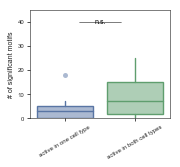

In [36]:
fig = plt.figure(figsize=(2.5, 2))
ax = sns.boxplot(data=results_df, x="type", y="n_sig_motifs", flierprops = dict(marker='o', markersize=5))
ax.set_xticklabels(["active in one cell type", "active in both cell types"], rotation=30)
mimic_r_boxplot(ax)
plt.xlabel("")
plt.ylabel("# of significant motifs")
plt.ylim((-0.1, 45))


# calc p-vals b/w dists
one_dist = np.asarray(results_df[results_df["type"] == "on in hepg2, not k562"]["n_sig_motifs"])
both_dist = np.asarray(results_df[results_df["type"] == "on in both"]["n_sig_motifs"])

one_dist = one_dist[~np.isnan(one_dist)]
both_dist = both_dist[~np.isnan(both_dist)]

u, pval = stats.mannwhitneyu(one_dist, both_dist, alternative="less", use_continuity=False)

# statistical annotation
annotate_pval(ax, 0.2, 0.8, 40, 0, 39, pval, fontsize)

fig.savefig("Fig_S11.pdf", dpi="figure", bbox_inches="tight")

In [37]:
pval

0.061319607351473127

## 8. plot correlation b/w number of motifs found and ref tile activity

In [38]:
hepg2_dict = {}
k562_dict = {}

for del_dict, motif_dict, d in zip([hepg2_data_peaks, k562_data_peaks], 
                                   [hepg2_motif_dfs, k562_motif_dfs], 
                                   [hepg2_dict, k562_dict]):
    for key in del_dict:
        df = del_dict[key]
        wt_activ = df["wt_activ"].iloc[0]
        
        # find num sig motifs
        motifs = motif_dict[key]
        n_tot_sig = len(list(set(list(motifs["motif"]))))
            
        d[key] = [wt_activ, n_tot_sig]

In [39]:
hepg2_activ = pd.DataFrame.from_dict(hepg2_dict, orient="index").reset_index()
hepg2_activ.columns = ["seq_name", "activ", "n_sig"]

k562_activ = pd.DataFrame.from_dict(k562_dict, orient="index").reset_index()
k562_activ.columns = ["seq_name", "activ", "n_sig"]

In [40]:
hepg2_activ.head()

,seq_name,activ,n_sig
0,enhancer_NEAT1__pX__tile2__minus,0.024331,12
1,enhancer_MALAT1__pX__tile1__minus,-0.116371,20
2,enhancer_MALAT1__pX__tile2__minus,3.202182,9
3,enhancer_TERC__pX__tile2__minus,-0.504331,2
4,enhancer_LINC_PINT__pX__tile1__minus,0.060140,34


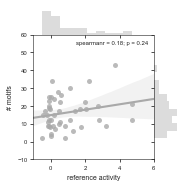

In [41]:
g = sns.jointplot(data=hepg2_activ, x="activ", y="n_sig", kind="reg", space=0, size=2.625, stat_func=spearmanr, 
                  marginal_kws={"hist": True, "kde": False, "bins": 10}, color="darkgrey", scatter_kws={"s": 25},
                  xlim=(-1, 6), ylim=(-10, 60))
g.set_axis_labels("reference activity", "# motifs")

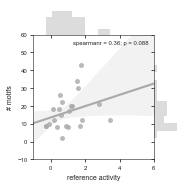

In [42]:
g = sns.jointplot(data=k562_activ, x="activ", y="n_sig", kind="reg", space=0, size=2.625, stat_func=spearmanr, 
                  marginal_kws={"hist": True, "kde": False, "bins": 10}, color="darkgrey", scatter_kws={"s": 25},
                  xlim=(-1, 6), ylim=(-10, 60))
g.set_axis_labels("reference activity", "# motifs")